<a href="https://colab.research.google.com/github/christopher-reed/UCLA-New-Mexico/blob/master/New_Mexico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PDF Scraping Scrap

In [0]:
import pandas as pd
import numpy as np
import regex as re

In [0]:
!pip install tika
import tika
from tika import parser

In [0]:
#Read pdf
parsedPDF = parser.from_file('/content/drive/My Drive/Practicum 2019 - WildEarth Guardians/2. Winter 2020/Permits/Permits/Application (6925).pdf')
#parsedPDF = parser.from_file('/content/drive/My Drive/Practicum 2019 - WildEarth Guardians/2. Winter 2020/Permits/Permits/Application (7232M1).pdf') #owner does not work

##Process lat and long
#Find phrases
lat_result = re.search('Latitude.*N', parsedPDF['content']).group(0)
lon_result = re.search('Longitude.*W', parsedPDF['content']).group(0)

#Remove portion of phrase
lat_result = lat_result.strip('Latitude (deg., min., sec.):')
lon_result = lon_result.strip('Longitude (deg., min., sec.):')

##Process facility name
#Find phrases
facility_name = re.search('Facility Name:\s+(.*)', parsedPDF['content']).group(0).partition('P')[0]

#Remove portion of phrase
facility_name = facility_name.strip('Facility Name: ')

##Company Name
company_name = re.search('Plant Operator Company Name:\s+(.*)', parsedPDF['content']).group(0).partition('Phone')[0]
company_name = company_name.strip('Plant Operator Company Name: ')

##Find whose land it is on 
potential_owners = ['Private', 'Indian/Pueblo', 'Federal BLM', 'Federal Forest Service', 'Other']
off = '\uf0ff'
for owner in potential_owners:
  start_index = parsedPDF['content'].find(owner)
  list_words = list(parsedPDF['content'][start_index-3:start_index+5])
  print(owner, list_words)
  if off not in list_words:
    actual_owner = owner
    break

  else:
    continue

In [0]:
actual_owner

'Other'

In [0]:
parsedPDF['content'][23746:23850]

In [0]:
parsedPDF['content'].find('been constructed?')
parsedPDF['content'][23286:23400]

In [0]:
parsedPDF['content'].find('1972')
parsedPDF['content'][23881:24000]

In [0]:
parsedPDF['content'].find('Datum')
parsedPDF['content'][25255:25400]

In [0]:
#The one that does not have \u next to it
parsedPDF['content'].find('Status of land')
parsedPDF['content'][26674:26800]

In [0]:
#Take each label and 4 spaces before it. Does it contain off?
parsedPDF['content'][26674:26800]

In [0]:
private_start = parsedPDF['content'].find('Private')
indian_start = parsedPDF['content'].find('Indian/Pueblo')
federalBLM_start = parsedPDF['content'].find('Federal BLM')
federalForest_start = parsedPDF['content'].find('Federal Forest Service')
other_start = parsedPDF['content'].find('Other')

print(parsedPDF['content'][private_start-3:private_start+7].find('Off'))
print(parsedPDF['content'][indian_start-3:indian_start+5].find('Off'))
print(parsedPDF['content'][federalBLM_start-3:federalBLM_start+5].find('Off'))
print(parsedPDF['content'][federalForest_start-3:federalForest_start+5].find('Off'))
print(parsedPDF['content'][other_start-3:other_start+5].find('Off'))

In [0]:
off in list(parsedPDF['content'][other_start-3:other_start+5])

In [0]:
#This is how we wil find if the button is on or off!
off = '\uf0ff'
off in list(parsedPDF['content'][federalForest_start-3:federalForest_start+5])

In [0]:
potential_owners = ['Private', 'Indian/Pueblo', 'Federal BLM', 'Federal Forest Service', 'Other']
off = '\uf0ff'
for owner in potential_owners:
  start_index = parsedPDF['content'].find(owner)
  list_words = list(parsedPDF['content'][start_index-3:start_index+5])
  print(owner, list_words)
  if off not in list_words:
    actual_owner = owner


  else:
    continue

In [0]:
all(elem not in ['�', '\uf0ff'] for elem in list_words)

In [0]:
#Read pdf
parsedPDF = parser.from_file('/content/drive/My Drive/Practicum 2019 - WildEarth Guardians/2. Winter 2020/Permits/Permits/Application (6925).pdf')
#parsedPDF = parser.from_file('/content/drive/My Drive/Practicum 2019 - WildEarth Guardians/2. Winter 2020/Permits/Permits/Application (7232M1).pdf')
#parsedPDF = parser.from_file('/content/drive/My Drive/Practicum 2019 - WildEarth Guardians/2. Winter 2020/Permits/Permits/Application (8324).pdf')


##Process lat and long
#Find phrases
lat_result = re.search('Latitude.*N', parsedPDF['content']).group(0)
lon_result = re.search('Longitude.*W', parsedPDF['content']).group(0)

#Remove portion of phrase
lat_result = lat_result.strip('Latitude (deg., min., sec.):')
lon_result = lon_result.strip('Longitude (deg., min., sec.):')

#Convert dms to dd
deg, minutes, sec, direc = re.split('[°\'"\s]+', lon_result)
dd = float(deg) + float(minutes)/60 + float(sec)/3600
dd_lon = dd * (-1 if direc in ['W','S'] else 1)

deg, minutes, sec, direc = re.split('[°\'"\s]+', lat_result)
dd = float(deg) + float(minutes)/60 + float(sec)/3600
dd_lat = dd * (-1 if direc in ['W','S'] else 1)

##Process facility name
#Find phrases
facility_name = re.search('Facility Name:\s+(.*)', parsedPDF['content']).group(0).partition('P')[0]

#Remove portion of phrase
facility_name = facility_name.strip('Facility Name: ')

##Company Name
company_name = re.search('Plant Operator Company Name:\s+(.*)', parsedPDF['content']).group(0).partition('Phone')[0]
company_name = re.search("(?<=:).*",company_name).group(0).strip()

###Find land owner if possible
##Check if possible by searching for characters indicating check marks
#Find key word Status of Land, Land Status, or some combination thereof
key_word = re.search(r'\b(?:Land\W+(?:\w+\W+){0,5}?Status|Status\W+(?:\w+\W+){0,5}?Land)\b', parsedPDF['content'], re.IGNORECASE).group(0)

#Focus search area around key word
start_index = parsedPDF['content'].find(key_word)

#150 characters passed key word is the key area
key_area = parsedPDF['content'][start_index:start_index+150]

off_words = ['�', '\uf0ff']
if any(x in key_area for x in off_words):
  #potential owner names
  potential_owners = ['Private', 'Indian/Pueblo', 'Federal BLM', 'BLM', 'Federal Forest Service', 'Forest Service', 'Other']

  #Iterate through owner names to find text near them
  for owner in potential_owners:
    start_index = parsedPDF['content'].find(owner)
    list_words = list(parsedPDF['content'][start_index-3:start_index+5])
    
    #Check if text does not have off words meaning they are the owner
    if all(elem not in off_words for elem in list_words):
      actual_owner = owner

    #Check other owners
    else:
      continue

#If no check marks then not possible to identify owner
else:
  actual_owner = 'Not possible to identify by code'

In [0]:
#Read pdf
parsedPDF = parser.from_file('/content/drive/My Drive/Practicum 2019 - WildEarth Guardians/2. Winter 2020/Permits/Permits/Application (6925).pdf')
#parsedPDF = parser.from_file('/content/drive/My Drive/Practicum 2019 - WildEarth Guardians/2. Winter 2020/Permits/Permits/Application (7232M1).pdf')
#parsedPDF = parser.from_file('/content/drive/My Drive/Practicum 2019 - WildEarth Guardians/2. Winter 2020/Permits/Permits/Application (8324).pdf')

#Dictionary
facility_dict = {}

##Process lat and long
#Find phrases
lat_result = re.search('Latitude.*N', parsedPDF['content']).group(0)
lon_result = re.search('Longitude.*W', parsedPDF['content']).group(0)

#Remove portion of phrase
lat_result = lat_result.strip('Latitude (deg., min., sec.):')
lon_result = lon_result.strip('Longitude (deg., min., sec.):')

#Convert dms to dd
deg, minutes, sec, direc = re.split('[°\'"\s]+', lon_result)
dd = float(deg) + float(minutes)/60 + float(sec)/3600
dd_lon = dd * (-1 if direc in ['W','S'] else 1)

deg, minutes, sec, direc = re.split('[°\'"\s]+', lat_result)
dd = float(deg) + float(minutes)/60 + float(sec)/3600
dd_lat = dd * (-1 if direc in ['W','S'] else 1)

##Process facility name
#Find phrases
facility_name = re.search('Facility Name:\s+(.*)', parsedPDF['content']).group(0).partition('P')[0]

#Remove portion of phrase
facility_name = facility_name.strip('Facility Name: ')

##Company Name
company_name = re.search('Plant Operator Company Name:\s+(.*)', parsedPDF['content']).group(0).partition('Phone')[0]
company_name = re.search("(?<=:).*",company_name).group(0).strip()

###Find land owner if possible
##Check if possible by searching for characters indicating check marks
#Find key word Status of Land, Land Status, or some combination thereof
key_word = re.search(r'\b(?:Land\W+(?:\w+\W+){0,5}?Status|Status\W+(?:\w+\W+){0,5}?Land)\b', parsedPDF['content'], re.IGNORECASE).group(0)

#Focus search area around key word
start_index = parsedPDF['content'].find(key_word)

#150 characters passed key word is the key area
key_area = parsedPDF['content'][start_index:start_index+150]

off_words = ['�', '\uf0ff']
if any(x in key_area for x in off_words):
  #potential owner names
  potential_owners = ['Private', 'Indian/Pueblo', 'Federal BLM', 'BLM', 'Federal Forest Service', 'Forest Service', 'Other']

  #Iterate through owner names to find text near them
  for owner in potential_owners:
    start_index = parsedPDF['content'].find(owner)
    list_words = list(parsedPDF['content'][start_index-3:start_index+5])
    
    #Check if text does not have off words meaning they are the owner
    if all(elem not in off_words for elem in list_words):
      actual_owner = owner

    #Check other owners
    else:
      continue

#If no check marks then not possible to identify owner
else:
  actual_owner = 'Not possible to identify by code'

facility_dict[facility_name] = [dd_lon, dd_lat, company_name, actual_owner]



##OLD 
# #Some PDFs don't have any characters to indicate a check. Also use different terms for each other (BLM vs Federal BLM)
# potential_owners = ['Private', 'Indian/Pueblo', 'Federal BLM', 'BLM', 'Federal Forest Service', 'Forest Service', 'Other']
# off_words = ['�', '\uf0ff']

# for owner in potential_owners:
#   start_index = parsedPDF['content'].find(owner)
#   list_words = list(parsedPDF['content'][start_index-3:start_index+5])
#   print(owner, list_words)
#   if all(elem not in ['�', '\uf0ff'] for elem in list_words):
#     actual_owner = owner


#   else:
#     continue

In [0]:
import os

#Function to clean coordinates
def int_decimal(string):
  return re.sub(r'[^\d.]+', '', string)

facility_dict = {}

for filename in os.listdir('/content/drive/My Drive/Practicum 2019 - WildEarth Guardians/2. Winter 2020/Permits/Permits'):
  if filename.endswith("pdf") and 'Update' not in filename:
    parsedPDF = parser.from_file('/content/drive/My Drive/Practicum 2019 - WildEarth Guardians/2. Winter 2020/Permits/Permits/' + filename)
    print(filename)
    ##Process lat and long
    #Find phrases
    if re.search('longitude', parsedPDF['content'],re.IGNORECASE) == None:
      dd_lon = 'Longitude not detected'
      dd_lat = 'Latitude not detected'

    else:
      lat_result = re.search('Latitude.*N', parsedPDF['content']).group(0)
      lon_result = re.search('Longitude.*W', parsedPDF['content']).group(0)

      #Remove portion of phrase
      lat_result = lat_result.strip('Latitude (deg., min., sec.):')
      lon_result = lon_result.strip('Longitude (deg., min., sec.):')

      #Convert dms to dd
      deg, minutes, sec, direc = re.split('[°\'"\s]+', lon_result)

      deg = int_decimal(deg)
      minutes = int_decimal(minutes)
      sec = int_decimal(sec)

      dd = float(deg) + float(minutes)/60 + float(sec)/3600
      dd_lon = dd * (-1 if direc in ['W','S'] else 1)

      deg, minutes, sec, direc = re.split('[°\'"\s]+', lat_result)

      deg = int_decimal(deg)
      minutes = int_decimal(minutes)
      sec = int_decimal(sec)

      dd = float(deg) + float(minutes)/60 + float(sec)/3600
      dd_lat = dd * (-1 if direc in ['W','S'] else 1)

    ##Process facility name
    #Find phrases
    if parsedPDF['content'].find('Facility Name') == -1:
      facility_name = 'Facility name not detected'

    else:
      facility_name = re.search('Facility Name:\s+(.*)', parsedPDF['content']).group(0).partition('P')[0]

      #Remove portion of phrase
      facility_name = facility_name.strip('Facility Name: ')

    ##Company Name
    if parsedPDF['content'].find('Plant Operator Company Name') == -1:
      company_name = 'Company name not detected'

    else:
      company_name = re.search('Plant Operator Company Name:\s+(.*)', parsedPDF['content']).group(0).partition('Phone')[0]
      company_name = re.search("(?<=:).*",company_name).group(0).strip()

    ###Find land owner if possible
    ##Check if possible by searching for characters indicating check marks
    #Find key word Status of Land, Land Status, or some combination thereof
    key_word = re.search(r'\b(?:Land\W+(?:\w+\W+){0,5}?Status|Status\W+(?:\w+\W+){0,5}?Land)\b', parsedPDF['content'], re.IGNORECASE)

    if key_word == None:
      actual_owner = 'Owner not detected'

    else:
      key_word = key_word.group(0)

      #Focus search area around key word
      start_index = parsedPDF['content'].find(key_word)

      #150 characters passed key word is the key area
      key_area = parsedPDF['content'][start_index:start_index+150]

      off_words = ['�', '\uf0ff']
      if any(x in key_area for x in off_words):
        #potential owner names
        potential_owners = ['Private', 'Indian/Pueblo', 'Federal BLM', 'BLM', 'Federal Forest Service', 'Forest Service', 'Other']

        #Iterate through owner names to find text near them
        for owner in potential_owners:
          start_index = parsedPDF['content'].find(owner)
          list_words = list(parsedPDF['content'][start_index-3:start_index+5])
          
          #Check if text does not have off words meaning they are the owner
          if all(elem not in off_words for elem in list_words):
            actual_owner = owner

          #Check other owners
          else:
            continue

      #If no check marks then not possible to identify owner
      else:
        actual_owner = 'Not possible to identify by code'

    facility_dict[filename] = [dd_lon, dd_lat, company_name, actual_owner, facility_name]
    
  else:
    continue

In [0]:
pd.DataFrame.from_dict(facility_dict)

In [0]:

parsedPDF = parser.from_file('/content/drive/My Drive/Practicum 2019 - WildEarth Guardians/2. Winter 2020/Permits/Permits/Application (6846R3).pdf')
key_word = re.search(r'\b(?:Land\W+(?:\w+\W+){0,5}?Status|Status\W+(?:\w+\W+){0,5}?Land)\b', parsedPDF['content'], re.IGNORECASE)

if key_word == None:
  actual_owner = 'Owner not detected'

else:
  key_word = key_word.group(0)

  #Focus search area around key word
  start_index = parsedPDF['content'].find(key_word)

  #150 characters passed key word is the key area
  key_area = parsedPDF['content'][start_index:start_index+150]

  off_words = ['�', '\uf0ff']
  if any(x in key_area for x in off_words):
    #potential owner names
    potential_owners = ['Private', 'Indian/Pueblo', 'Federal BLM', 'BLM', 'Federal Forest Service', 'Forest Service', 'Other']

    #Iterate through owner names to find text near them
    for owner in potential_owners:
      start_index = parsedPDF['content'].find(owner)
      list_words = list(parsedPDF['content'][start_index-3:start_index+5])
      
      #Check if text does not have off words meaning they are the owner
      if all(elem not in off_words for elem in list_words):
        actual_owner = owner

      #Check other owners
      else:
        continue

  #If no check marks then not possible to identify owner
  else:
    actual_owner = 'Not possible to identify by code'

print(actual_owner)

In [0]:
key_area

In [0]:
#Test private
parsedPDF['content'].find('Forest Service')
list_words = list(parsedPDF['content'][10015-3:10015+5])
print(list_words)
if all(elem not in off_words for elem in list_words):
  print('gottem')

else:
  print('not here boss')

In [0]:
parsedPDF['content'][10015-3:10015+5]

In [0]:
if key_area.find('Federal Forest Service') == -1:
  potential_owner = 'Forest Service'
  start_index = parsedPDF['content'].find(potential_owner)
  list_words = list(parsedPDF['content'][start_index-3:start_index])
  print(list_words)

else:
  potential_owner = 'Federal Forest Service'
  start_index = parsedPDF['content'].find(potential_owner)
  list_words = list(parsedPDF['content'][start_index-3:start_index])
  print(list_words)




In [0]:
#New
import os
import pandas as pd
import numpy as np

#Function to clean coordinates
def int_decimal(string):
  return re.sub(r'[^\d.]+', '', string)

facility_dict = {}

#for filename in os.listdir('/content/drive/My Drive/Practicum 2019 - WildEarth Guardians/2. Winter 2020/Permits/Permits'):
for filename in os.listdir('/content/drive/My Drive/Practicum 2019 - WildEarth Guardians/2. Winter 2020/Permits/Permits'):
  if filename.endswith("pdf") and 'Update' not in filename:
    parsedPDF = parser.from_file('/content/drive/My Drive/Practicum 2019 - WildEarth Guardians/2. Winter 2020/Permits/Permits/' + filename)
    print(filename)
    ##Process lat and long
    #Find phrases
    if re.search('longitude', parsedPDF['content'],re.IGNORECASE) == None:
      dd_lon = 'Longitude not detected'
      dd_lat = 'Latitude not detected'

    else:
      lat_result = re.search('Latitude.*N', parsedPDF['content']).group(0)
      lon_result = re.search('Longitude.*W', parsedPDF['content']).group(0)

      #Remove portion of phrase
      lat_result = lat_result.strip('Latitude (deg., min., sec.):')
      lon_result = lon_result.strip('Longitude (deg., min., sec.):')

      #Convert dms to dd
      deg, minutes, sec, direc = re.split('[°\'"\s]+', lon_result)

      deg = int_decimal(deg)
      minutes = int_decimal(minutes)
      sec = int_decimal(sec)

      dd = float(deg) + float(minutes)/60 + float(sec)/3600
      dd_lon = dd * (-1 if direc in ['W','S'] else 1)

      deg, minutes, sec, direc = re.split('[°\'"\s]+', lat_result)

      deg = int_decimal(deg)
      minutes = int_decimal(minutes)
      sec = int_decimal(sec)

      dd = float(deg) + float(minutes)/60 + float(sec)/3600
      dd_lat = dd * (-1 if direc in ['W','S'] else 1)

    ##Process facility name
    #Find phrases
    if parsedPDF['content'].find('Facility Name') == -1:
      facility_name = 'Facility name not detected'

    else:
      facility_name = re.search('Facility Name:\s+(.*)', parsedPDF['content']).group(0).partition('Pl')[0]

      #Remove portion of phrase
      facility_name = facility_name.strip('Facility Name: ')

      #Remove \n
      facility_name = re.sub('\n','',facility_name)

    ##Company Name
    if parsedPDF['content'].find('Plant Operator Company Name') == -1:
      company_name = 'Company name not detected'

    else:
      company_name = re.search('Plant Operator Company Name:\s+(.*)', parsedPDF['content']).group(0).partition('Phone')[0]
      company_name = re.search("(?<=:).*",company_name).group(0).strip()

    ###Find land owner if possible
    ##Check if possible by searching for characters indicating check marks
    #Find key word Status of Land, Land Status, or some combination thereof
    key_word = re.search(r'\b(?:Land\W+(?:\w+\W+){0,5}?Status|Status\W+(?:\w+\W+){0,5}?Land)\b', parsedPDF['content'], re.IGNORECASE)

    if key_word == None:
      actual_owner = 'Owner not detected'

    else:
      key_word = key_word.group(0)

      #Focus search area around key word
      start_index = parsedPDF['content'].find(key_word)

      #150 characters passed key word is the key area
      key_area = parsedPDF['content'][start_index:start_index+150]

      off_words = ['�', '\uf0ff']
      if any(x in key_area for x in off_words):

        #Potential owner names
        potential_owners = ['Private', 'Indian/Pueblo', 'Federal BLM', 'Federal Forest Service', 'Other']

        #Iterate through owner names to find text near them
        for owner in potential_owners:

          #Special case for BLM bc multiple naming conventions
          if owner == 'Federal BLM':

            #Federal BLM not found, try alternate convention of BLM
            if key_area.find('Federal BLM') == -1:
              potential_owner = 'BLM'
              start_index = parsedODF['content'].find(potential_owner)
              list_words = list(parsedPDF['content'][start_index-3:start_index])

              if all(elem not in off_words for elem in list_words):
                actual_owner = owner

                #Owner found move on
                break

              #Owner is not BLM
              else:
                continue

            #Federal BLM found, use that convention
            else:
                potential_owner = 'Federal BLM'
                start_index = parsedPDF['content'].find(potential_owner)
                list_words = list(parsedPDF['content'][start_index-3:start_index])

                #Check if off words are NOT IN list of characters
                if all(elem not in off_words for elem in list_words):
                  actual_owner = owner

                  #Owner found move on
                  break

                #Owner is not Federal BLM
                else:
                  continue

          #Special case for forest service bc multiple naming conventions
          elif owner == 'Federal Forest Service':

            #Federal Forest Service not found, try alternate convention of Forest Service
            if key_area.find('Federal Forest Service') == -1:
              potential_owner = 'Forest Service'
              start_index = parsedPDF['content'].find(potential_owner)
              list_words = list(parsedPDF['content'][start_index-3:start_index])

              #Check if off words are NOT IN list of characters
              if all(elem not in off_words for elem in list_words):
                actual_owner = owner

                #Owner found move on
                break

              #Owner is not Forest Service
              else:
                continue


            #Federal Forest Service found, use that convention
            else:
              potential_owner = 'Federal Forest Service'
              start_index = parsedPDF['content'].find(potential_owner)
              list_words = list(parsedPDF['content'][start_index-3:start_index])
              
              #Check if off words are NOT IN list of characters
              if all(elem not in off_words for elem in list_words):
                actual_owner = owner

                #Owner found move on
                break
              
              #Owner is not Federal Forest Service
              else:
                continue

          #All non-special cases (Private, Indian,, Other)
          else:
            start_index = parsedPDF['content'].find(owner)
            list_words = list(parsedPDF['content'][start_index-3:start_index])
            
            #Check if text does not have off words meaning they are the owner
            if all(elem not in off_words for elem in list_words):
              actual_owner = owner
              #Owner found move on  
              break

            #Check other owners
            else:
              continue
      else:
        actual_owner = 'Not possible to identify by code'

    #Collect results
    facility_dict[filename] = [dd_lon, dd_lat, company_name, actual_owner, facility_name]

  #File is not a pdf, go next
  else:
    continue

In [0]:
df = pd.DataFrame.from_dict(facility_dict)
df = df.T
df = df.reset_index(drop = True)
df = df.rename(columns = {0:'Lon', 1:'Lat', 2:'Company Name', 3:'Land Ownernship', 4:'Facility Name'})
df.head()

In [0]:
dd_lat

# SPUD Date and APD
Source: https://wwwapps.emnrd.state.nm.us/ocd/ocdpermitting/Data/Wells.aspx

## Import necessary packages

In [0]:
!pip install fiona
!pip install geopandas

     |████████████████████████████████| 14.7MB 340kB/s 
     |████████████████████████████████| 931kB 2.8MB/s 
     |████████████████████████████████| 10.4MB 16.3MB/s 


In [0]:
from ftplib import FTP
from bs4 import BeautifulSoup
from bs4 import SoupStrainer
import requests
import time
import fiona
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Collect Data

**Collect geospatial data from OCD website. Link: ftp://164.64.106.6/Public/OCD/OCD%20GIS%20Data/** 

In [0]:
#Connect to FTP
ftp = FTP('164.64.106.6')
ftp.login()

#Move to directory
ftp.cwd('/Public/OCD/OCD GIS Data/Geodatabase/')

#Download file
file = 'NMOCD_GISData.gdb.zip'
ftp.retrbinary('RETR ' + file, open(file, 'wb').write)

#Unzip
!unzip /content/NMOCD_GISData.gdb.zip

#Parse feature class from gdb
layers = fiona.listlayers('/content/drive/My Drive/Practicum 2019 - WildEarth Guardians/Data/Geospatial/Wells/NMOCD_GISData.gdb')
df_wells = gpd.read_file('/content/drive/My Drive/Practicum 2019 - WildEarth Guardians/Data/Geospatial/Wells/NMOCD_GISData.gdb', layer = 'WellGIS')

#Collect apis
apis = df_wells['id']

#Rename api
df_wells = df_wells.rename(columns = {'id':'API_geospatial'})

#Inspect
df_wells.head()

TimeoutError: ignored

**Can also download on your machine locally and upload them.**

In [0]:
#If FTP is not connecting then use the downloaded version of the dataset.
layers = fiona.listlayers('/content/drive/My Drive/Practicum 2019 - WildEarth Guardians/Data/Geospatial/Wells/NMOCD_GISData.gdb')
df_wells = gpd.read_file('/content/drive/My Drive/Practicum 2019 - WildEarth Guardians/Data/Geospatial/Wells/NMOCD_GISData.gdb', layer = 'WellGIS')

apis = df_wells['id']

df_wells = df_wells.rename(columns = {'id':'API_geospatial'})

df_wells.head()

**Following cell scrapes the OCD well database. Note: Code takes 85 hours to scrape every single well api so use carefully.**

Link: https://wwwapps.emnrd.state.nm.us/ocd/ocdpermitting/Data/Wells.aspx

In [0]:
well_dict = {}

base_url = 'https://wwwapps.emnrd.state.nm.us/ocd/ocdpermitting/Data/WellDetails.aspx?api='

for num, api in enumerate(apis):
  url = base_url + str(api)
  response = requests.request("GET", url)

  soup = BeautifulSoup(response.content)

  well_dict[str(api)] = [soup.find(id = 'ctl00_ctl00__main_main_ucGeneralWellInformation_lblSpudDate').get_text(),
                             soup.find(id = 'ctl00_ctl00__main_main_ucGeneralWellInformation_lblApdInitialApprovalDate').get_text(),
                             soup.find(id = 'ctl00_ctl00__main_main_ucGeneralWellInformation_lblApdEffectiveDate').get_text()]

  if num % 250 == 0:
    print(num)

  else:
    continue

  time.sleep(0.5)
  break

**Alternative is to just download to OCD well data set (2/20/2020). May not be up to date if analysis run at later date.**

In [0]:
data = pd.read_html('/content/drive/My Drive/Practicum 2019 - WildEarth Guardians/Data/Not Geospatial/OCD Well Dataset.xls')
expanded_wells_df = data[0]
expanded_wells_df = expanded_wells_df[['API', 'Initial APD Approval Date', 'Spud Date']]
expanded_wells_df.head()

**Join the geospatial data from OCD and the downloaded well site data from OCD to see if records are missing. The first three columns are from the downloaded wellsite data. If there are ant NaNs in the API then that means there is data missing from the downloaded well site data.**

In [0]:
#Join dfs together to we have the api and apd dates
df_complete_wells = expanded_wells_df.merge(df_wells, left_on = 'API', right_on = 'API_geospatial', how = 'right')
df_complete_wells.head()

**How many wells are there?**

In [0]:
df_complete_wells.shape

**How many wells do not have an inital APD approval date?**

In [0]:
df_complete_wells[df_complete_wells['Initial APD Approval Date'].isnull()].shape

In [0]:
subset = df_complete_wells[(df_complete_wells['county'] == 'San Juan') & (df_complete_wells['ogrid_name'].str.contains('WPX')) & (df_complete_wells['status_code'] != 'C')]
subset.head()

In [0]:
#Scrape away!
apis = subset['API_geospatial']

well_dict = {}

base_url = 'https://wwwapps.emnrd.state.nm.us/ocd/ocdpermitting/Data/WellDetails.aspx?api='

for num, api in enumerate(apis):
  url = base_url + str(api)
  response = requests.request("GET", url)

  soup = BeautifulSoup(response.content)

  well_dict[str(api)] = [soup.find(id = 'ctl00_ctl00__main_main_ucGeneralWellInformation_lblSpudDate').get_text(),
                             soup.find(id = 'ctl00_ctl00__main_main_ucGeneralWellInformation_lblApdInitialApprovalDate').get_text(),
                             soup.find(id = 'ctl00_ctl00__main_main_ucGeneralWellInformation_lblApdEffectiveDate').get_text(),
                         soup.find(id = 'ctl00_ctl00__main_main_ucGeneralWellInformation_lblPluggedDate').get_text()]

  if num % 10 == 0:
    print(num)

  else:
    continue

  time.sleep(0.5)

In [0]:
df = pd.DataFrame.from_dict(well_dict).T.reset_index()
df = df.rename(columns = {'index':'API',0:'spud', 1:'Initial APD', 2:'Most recent APD', 3:'Plug date'})
df

In [0]:
#Focus on San Juan county
san_juan = df_complete_wells[df_complete_wells['county'] == 'San Juan']

san_juan['Initial APD Approval Date'] = pd.to_datetime(san_juan['Initial APD Approval Date'])
san_juan['Spud Date'] = pd.to_datetime(san_juan['Spud Date'])

#What are most prominent companies in SJ
sj_count = san_juan.groupby('ogrid_name').count().reset_index()

In [0]:
#How many wells apis do companies have in san juan with a inital apd approval 2005 and newer
company_count = {}
for company in san_juan['ogrid_name'].unique():
  df = san_juan[(san_juan['ogrid_name'] == company) & (san_juan['ogrid_name'] == company) & (san_juan['status_code'] == 'N')]

  num_ops = df.shape[0]

  #Only take company name and count if more than 5 new ops
  if num_ops > 5:
    company_count[company] = [df.shape[0]]

  #If 5 or less move on
  else:
    continue

In [0]:
san_juan.sort_values(by = 'Spud Date', ascending=False).head(30)

In [0]:
df = pd.DataFrame.from_dict(company_count).T.reset_index()
df = df.rename(columns = {'index':'Company', 0:'Number New Operations'})
df = df.sort_values(by = 'Number New Operations')

#Plot num new operations by company
fig, ax = plt.subplots(figsize = (8,5))
ax = sns.barplot(x = 'Company', y = 'Number New Operations', data = df, color = 'steelblue')

plt.xticks(rotation = 45)
ax.set_xticklabels(['Juniper', 'Vision', 'Logos', 'Dugan', 'XTO', 'BP America', 'NMOGC', 'Hilcorp', 'Enduring', 'DJR'])

ax.set_title('Number of New Operations in San Juan County, NM')

**Focus on just Hilcorp and Enduring in San Juan.**

In [0]:
hilcorp_sanjuan = san_juan[(san_juan['ogrid_name'].str.contains('HILCORP')) & (san_juan['status_code'] == 'N')]
enduring_sanjuan = san_juan[(san_juan['ogrid_name'].str.contains('ENDURING')) & (san_juan['status_code'] == 'N')]

Python approach to grouping wells: https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/

In [0]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

## Enduring Analysis

In [0]:
df = enduring_sanjuan
coords = df.as_matrix(columns = ['latitude', 'longitude'])

In [0]:
#Plot all new
fig, ax = plt.subplots(figsize=[10, 6])
df_scatter = ax.scatter(df['longitude'], df['latitude'], c='k', alpha=0.9, s=3)
ax.set_title('Enduring New Wells')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter,], ['Enduring Well'], loc='upper right')
plt.show()

In [0]:
kms_per_radian = 6371.0088
epsilon = 0.2 / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

In [0]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)
centermost_points = clusters.map(get_centermost_point)

In [0]:
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})

In [0]:
rs = rep_points.apply(lambda row: df[(df['latitude']==row['lat'])&(df['longitude']==row['lon'])].iloc[0], axis=1)

In [0]:
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['longitude'], rs['latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(df['longitude'], df['latitude'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()

**For each row in df we need to know what cluster it was a part of.**




In [0]:
df['Cluster'] = np.nan

for i in range(len(clusters)):
  #Get ith cluster
  cluster = clusters[i]

  #Iterate through each coord pair in cluster
  for j in cluster:
   df.loc[(df['latitude'] == j[0]) & (df['longitude'] == j[1]), ['Cluster']] = int(i)

**Do same with center points (rs)**

In [0]:
rs['Cluster'] = np.nan

for i in range(len(clusters)):
  #Get ith cluster
  cluster = clusters[i]

  #Iterate through each coord pair in cluster
  for j in cluster:
   rs.loc[(rs['latitude'] == j[0]) & (rs['longitude'] == j[1]), ['Cluster']] = int(i)

Now we need to find the closest facilities to each cluster

In [0]:
facilities = pd.read_csv('/content/AQBP-LatLong-20-01-06.csv')

#Only oil and gas facilities in San Juan county
og_facilities = facilities[(facilities['Industry'].str.contains('O&G')) & (facilities['County'] == 'San Juan')]

#Filter out outliers by max lat and lon of well locations

#Bottom right: Must be less than or equal to this
max_lon = df['longitude'].max() + 0.1

#Bottom left: Must be greater than or equal to this 
min_lon = df['longitude'].min() - 0.1

#Top right: Must be less than or equal to this
max_lat = df['latitude'].max() +0.1

#Top: Must be greater than or equal to this
min_lat = df['latitude'].min() - 0.1

#Facilities inside the box (need to tweak boundaries)
og_facilities = og_facilities[(og_facilities['Latitude'].between(min_lat,max_lat, inclusive = True)) & (og_facilities['Longitude'].between(min_lon,max_lon, inclusive = True))]

In [0]:
facilities[facilities['Facility Name'].str.contains('787H')]

In [0]:
print(min_lat, max_lat)
print(min_lon, max_lon)

In [0]:
og_facilities[og_facilities['Facility Name'].str.contains('787H')]

In [0]:
print(min_lat, max_lat)
print(min_lon, max_lon)

Plot grouped wells and facilities together

In [0]:
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['longitude'], rs['latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
#df_scatter = ax.scatter(df['longitude'], df['latitude'], c='#99cc99', alpha=0.7, s=50)
fac_scatter = ax.scatter(og_facilities['Longitude'], og_facilities['Latitude'], c='black', edgecolor='None', alpha=0.7, s=25)

ax.set_title('Enduring Well Clusters vs Facility Location')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ax.legend([rs_scatter, fac_scatter], ['Well Clusters', 'Facilities'], loc='upper right')

In [0]:
import math

def haversine(coord1, coord2):
    R = 6372800  # Earth radius in meters
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))


In [0]:
coord1 = (36.26690, -107.697510)
coord2 = (36.254586, -107.714890)

haversine(coord1, coord2)
#In meters

In [0]:
#Find the distance between cluster center point and all facilities. If distance < 300 meters than give facility same cluster name

og_facilities['Cluster'] = np.nan

#Iterate through center points
for i in rs['API_geospatial'].unique():
  well_lat = rs[rs['API_geospatial'] == i]['latitude'].values[0]
  well_lon = rs[rs['API_geospatial'] == i]['longitude'].values[0]
  well_point = (well_lat, well_lon)

  #Get cluster values
  cluster_num = rs[rs['API_geospatial'] == i]['Cluster'].values[0]

  #Iterate through facilities
  for j in og_facilities['AI'].unique():
    fac_lat = og_facilities[og_facilities['AI'] == j]['Latitude'].values[0]
    fac_lon = og_facilities[og_facilities['AI'] == j]['Longitude'].values[0]
    fac_point = (fac_lat, fac_lon)

    distance = haversine(well_point, fac_point)

    if distance < 200:
      print(i, j, cluster_num)
      og_facilities.loc[og_facilities['AI'] == j, ['Cluster']] = cluster_num
      #Label it with cluster number of rs center point

    #Too far away to be associated
    else:
      continue

In [0]:
#So now we can join the facilities and wells df

df_well_fac = df.merge(og_facilities, on = 'Cluster', how = 'inner', suffixes = ('_well', '_fac'))

df_well_fac_filter = df_well_fac[['Initial APD Approval Date', 'name', 'ogrid_name', 'AI', 'Facility Name', 'Cluster']]

#Should be 8 rows because there are 4 wells and 2 facilities
df_well_fac_filter[df_well_fac_filter['Cluster'] == 5]

In [0]:
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['longitude'], rs['latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
#df_scatter = ax.scatter(df['longitude'], df['latitude'], c='#99cc99', alpha=0.7, s=50)
fac_scatter = sns.scatterplot(x= 'Longitude', y = 'Latitude', data = og_facilities, hue = 'Cluster')

ax.set_title('Enduring Well Clusters vs Facility Location')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ax.legend([rs_scatter, fac_scatter], ['Well Clusters', 'Facilities'], loc='upper right')

In [0]:
df_well_fac_filter['AI'].unique()

In [0]:
#In air map: 37765, 38839

In [0]:
#We need to know if the permits for these facilities are online are not
air_map_data = pd.read_csv('/content/nmed-aqb-rsmt-02-24-2020.csv')
air_map_data.head()

In [0]:
not_in = []
yes_in = []
#AI and NMED ID are the same thing
for i in df_well_fac_filter['AI'].unique():
  df = air_map_data[air_map_data['NMED ID'] == i]

  if df.shape[0] == 0:
    not_in.append(i)

  else:
    yes_in.append(i)

In [0]:
df_well_fac_filter.head()

In [0]:
air_map_data[air_map_data['Facility'] == 'Enduring Resources - Chaco 2308-061 No398H'].shape[0] == 0

In [0]:
not_in

In [0]:
yes_in

In [0]:
#Request permits for these guys
ais = df_well_fac_filter['AI'].unique()
og_facilities[og_facilities['AI'].isin(ais)]

In [0]:
len(not_in)

## Hilcorp Analysis

In [0]:
df = hilcorp_sanjuan = san_juan[(san_juan['ogrid_name'].str.contains('HILCORP')) & (san_juan['status_code'] == 'N')]
coords = df.as_matrix(columns = ['latitude', 'longitude'])

In [0]:
#Plot all new
fig, ax = plt.subplots(figsize=[10, 6])
df_scatter = ax.scatter(df['longitude'], df['latitude'], c='k', alpha=0.9, s=3)
ax.set_title('Enduring New Wells')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter,], ['Hilcorp Well'], loc='upper right')
plt.show()

In [0]:
kms_per_radian = 6371.0088
epsilon = 0.2 / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

In [0]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)
centermost_points = clusters.map(get_centermost_point)

In [0]:
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})

In [0]:
rs = rep_points.apply(lambda row: df[(df['latitude']==row['lat'])&(df['longitude']==row['lon'])].iloc[0], axis=1)

In [0]:
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['longitude'], rs['latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(df['longitude'], df['latitude'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='best')
plt.show()

In [0]:
df['Cluster'] = np.nan

for i in range(len(clusters)):
  #Get ith cluster
  cluster = clusters[i]

  #Iterate through each coord pair in cluster
  for j in cluster:
   df.loc[(df['latitude'] == j[0]) & (df['longitude'] == j[1]), ['Cluster']] = int(i)

In [0]:
rs['Cluster'] = np.nan

for i in range(len(clusters)):
  #Get ith cluster
  cluster = clusters[i]

  #Iterate through each coord pair in cluster
  for j in cluster:
   rs.loc[(rs['latitude'] == j[0]) & (rs['longitude'] == j[1]), ['Cluster']] = int(i)

In [0]:
facilities = pd.read_csv('/content/AQBP-LatLong-20-01-06.csv')

#Only oil and gas facilities in San Juan county
og_facilities = facilities[(facilities['Industry'].str.contains('O&G')) & (facilities['County'] == 'San Juan')]

#Filter out outliers by max lat and lon of well locations

#Bottom right: Must be less than or equal to this
max_lon = df['longitude'].max() + 0.1

#Bottom left: Must be greater than or equal to this 
min_lon = df['longitude'].min() - 0.1

#Top right: Must be less than or equal to this
max_lat = df['latitude'].max() +0.1

#Top: Must be greater than or equal to this
min_lat = df['latitude'].min() - 0.1

#Facilities inside the box (need to tweak boundaries)
og_facilities = og_facilities[(og_facilities['Latitude'].between(min_lat,max_lat, inclusive = True)) & (og_facilities['Longitude'].between(min_lon,max_lon, inclusive = True))]

In [0]:
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['longitude'], rs['latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
#df_scatter = ax.scatter(df['longitude'], df['latitude'], c='#99cc99', alpha=0.7, s=50)
fac_scatter = ax.scatter(og_facilities['Longitude'], og_facilities['Latitude'], c='black', edgecolor='None', alpha=0.7, s=25)

ax.set_title('Hilcorp Well Clusters vs Facility Location')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ax.legend([rs_scatter, fac_scatter], ['Well Clusters', 'Facilities'], loc='upper right')

In [0]:
og_facilities['Cluster'] = np.nan

#Iterate through center points
for i in rs['API_geospatial'].unique():
  well_lat = rs[rs['API_geospatial'] == i]['latitude'].values[0]
  well_lon = rs[rs['API_geospatial'] == i]['longitude'].values[0]
  well_point = (well_lat, well_lon)

  #Get cluster values
  cluster_num = rs[rs['API_geospatial'] == i]['Cluster'].values[0]

  #Iterate through facilities
  for j in og_facilities['AI'].unique():
    fac_lat = og_facilities[og_facilities['AI'] == j]['Latitude'].values[0]
    fac_lon = og_facilities[og_facilities['AI'] == j]['Longitude'].values[0]
    fac_point = (fac_lat, fac_lon)

    distance = haversine(well_point, fac_point)

    if distance < 200:
      print(i, j, cluster_num)
      og_facilities.loc[og_facilities['AI'] == j, ['Cluster']] = cluster_num
      #Label it with cluster number of rs center point

    #Too far away to be associated
    else:
      continue

In [0]:
#So now we can join the facilities and wells df

df_well_fac = df.merge(og_facilities, on = 'Cluster', how = 'inner', suffixes = ('_well', '_fac'))

df_well_fac_filter = df_well_fac[['Initial APD Approval Date', 'name', 'ogrid_name', 'AI', 'Facility Name', 'Cluster']]

#Should be 8 rows because there are 4 wells and 2 facilities
df_well_fac_filter[df_well_fac_filter['Cluster'] == 0]

In [0]:
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['longitude'], rs['latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
#df_scatter = ax.scatter(df['longitude'], df['latitude'], c='#99cc99', alpha=0.7, s=50)
fac_scatter = sns.scatterplot(x= 'Longitude', y = 'Latitude', data = og_facilities, hue = 'Cluster')

ax.set_title('Enduring Well Clusters vs Facility Location')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ax.legend([rs_scatter, fac_scatter], ['Well Clusters', 'Facilities'], loc='upper right')

# Week 9

Instead of looking for new wells we want to look for active wells. Plan here is to find active wels from Hilcorp and Endring from OCD's geospatial data (the onelacking the APD and spud).

In [0]:
#Find the wells from the geospatial dataset that are in San Juan County, operated by Hilcorp or Enduring, and have a status of Active

# 120782 = WPX ENERGY PRODUCTION, LLC, 
# 372286 = Enduring
# 372171 = Hilcorp

#Find apis
apis = df_wells[(df_wells['county'] == 'San Juan')&
                (df_wells['ogrid'].isin([120782, 372286, 372171]))&
                (df_wells['status'] == 'Active')]['API_geospatial']

#How many wells are there?
len(apis)

**Use the web scraper on the APIs we collected. This will take 2+ hours.**

In [0]:
#Scrape away!
well_dict = {}

base_url = 'https://wwwapps.emnrd.state.nm.us/ocd/ocdpermitting/Data/WellDetails.aspx?api='

interesting_content = SoupStrainer('div', {'class': 'left_column'})

for num, api in enumerate(apis):
  url = base_url + str(api)
  response = requests.request("GET", url)

  soup = BeautifulSoup(response.content, 'lxml', parse_only= interesting_content)

  well_dict[str(api)] = [soup.find(id = 'ctl00_ctl00__main_main_ucGeneralWellInformation_lblSpudDate').get_text(),
                             soup.find(id = 'ctl00_ctl00__main_main_ucGeneralWellInformation_lblApdInitialApprovalDate').get_text(),
                             soup.find(id = 'ctl00_ctl00__main_main_ucGeneralWellInformation_lblApdEffectiveDate').get_text()]

  if num % 10 == 0:
    print(num)

  else:
    continue

  time.sleep(0.25)

df = pd.DataFrame.from_dict(well_dict).T
df.to_csv('San_Juan.csv')

from google.colab import files
files.download('San_Juan.csv') 

**Convert dict to df and format**

In [0]:
df = pd.DataFrame.from_dict(well_dict).T
df1 = df.rename(columns = {0:'Spud Date', 1:'Initial APD', 2:'Recent APD'})
df1.to_csv('San_Juan.csv')

**Now we can use the scraped data.**

In [0]:
sj = pd.read_csv('/content/drive/My Drive/Practicum 2019 - WildEarth Guardians/Data/Not Geospatial/San_Juan.csv')

sj = sj.rename(columns = {'Unnamed: 0':'API'})

#Convert string dates to datetime
for col in sj.columns:
  if col == 'API':
    continue
  else:
    sj[col] = pd.to_datetime(sj[col])

#Preview
sj.head()

**So how many Spuds are in recent years?**

In [0]:
count_spuds = sj.groupby(sj['Spud Date'].dt.year).count()
count_spuds= count_spuds.rename(columns = {'Spud Date':'Num Spuds'})
count_spuds = count_spuds.reset_index()

fig, ax = plt.subplots(figsize = (18,5))

ax = sns.barplot(x = 'Spud Date', y = 'Num Spuds', data = count_spuds)

plt.xticks(rotation = 90)

ax.set_title('Number of SPUDS in Given Year\nActive Wells in San Juan County Operated by Hilcorp or Enduring')

**Now we need to join additional information about the well such as the company and location. Take this information from the geospatial dataset.**

In [0]:
##Load in geospatial data

#FTP version of this earlier in notebook
layers = fiona.listlayers('/content/drive/My Drive/Practicum 2019 - WildEarth Guardians/Data/Geospatial/Wells/NMOCD_GISData.gdb')
df_wells = gpd.read_file('/content/drive/My Drive/Practicum 2019 - WildEarth Guardians/Data/Geospatial/Wells/NMOCD_GISData.gdb', layer = 'WellGIS')

df_wells = df_wells.rename(columns = {'id':'API_geospatial'})

df_wells.head()

In [0]:
#Perform inner join
df = sj.merge(df_wells, left_on = 'API', right_on = 'API_geospatial', how = 'inner')

#Remove some excess columns
df = df.drop(columns = ['API_geospatial'])

df.head()

**We are only interested in wells that had a recent (since 2010) spud date.**

In [0]:
df_recent = df[df['Spud Date'].dt.year > 2009]

#How many wells are there?
df_recent.shape

#How many wells by each company?
plot=df_recent.groupby(['ogrid_name', df_recent['Spud Date'].dt.year]).count()
plot = plot.rename(columns = {'Spud Date':'Num Spud'})
plot = plot.reset_index()

g = sns.catplot(x = 'Spud Date', y = 'Num Spud', data = plot, hue = 'ogrid_name', kind = 'bar', palette = 'Reds')
axes = g.axes.flatten()
axes[0].set_title('Spuds per Year by Company')

**Now split by company and whether oil or gas well and begin clustering.**

In [0]:
hilcorp = df_recent[df_recent['ogrid_name'] == 'HILCORP ENERGY COMPANY']
hilcorp_gas = hilcorp[hilcorp['type_code'] == 'G']
hilcorp_oil = hilcorp[hilcorp['type_code'] == 'O']

enduring = df_recent[df_recent['ogrid_name'] == 'ENDURING RESOURCES, LLC']
enduring_gas = enduring[enduring['type_code'] == 'G']
enduring_oil = enduring[enduring['type_code'] == 'O']

In [0]:
#Dict for coloring well type

type_colors = {'Gas':'darkslateblue',
               'Oil':'mediumslateblue',
               'Salt Water Disposal':'plum'}

In [0]:
#Split between oil and gas wells for hilcorp?
plot = hilcorp.groupby(['type', df_recent['Spud Date'].dt.year]).count()
plot = plot.rename(columns = {'Spud Date':'Num Spud'})
plot = plot.reset_index()

g = sns.catplot(x = 'Spud Date', y = 'Num Spud', data = plot, hue = 'type', kind = 'bar', palette = type_colors)

axes = g.axes.flatten()
axes[0].set_title('Spuds per Year by Well Type\nHilcorp')
axes[0].set_ylabel('Number of Spuds')

In [0]:
plot = enduring.groupby(['type', df_recent['Spud Date'].dt.year]).count()
plot = plot.rename(columns = {'Spud Date':'Num Spud'})
plot = plot.reset_index()
g = sns.catplot(x = 'Spud Date', y = 'Num Spud', data = plot, hue = 'type', kind = 'bar', palette = type_colors)

axes = g.axes.flatten()
axes[0].set_title('Spuds per Year by Well Type\nEnduring')
axes[0].set_ylabel('Number of Spuds')

In [0]:
#Save these as csv for ArcMap
hilcorp.to_csv('hilcorp_active_sj.csv')
enduring.to_csv('enduring_active_sj.csv')

## Enduring Gas

In [0]:
#Plot all new gas wells for enduring
fig, ax = plt.subplots(figsize=[10, 6])
df_scatter = ax.scatter(enduring_gas['longitude'], enduring_gas['latitude'], c='k', alpha=0.9, s=3)

wells = enduring_gas.shape[0]

ax.set_title('Enduring New Wells\n' + str(wells) + ' Wells')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter,], ['Enduring Well'], loc='upper right')
plt.show()

In [0]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

In [0]:
coords = enduring_gas[['latitude', 'longitude']].values

kms_per_radian = 6371.0088
epsilon = 0.4 / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

In [0]:
# function as_matrix is now depricated.
# coords = enduring_gas.as_matrix(columns = ['latitude', 'longitude'])

# kms_per_radian = 6371.0088
# epsilon = 0.4 / kms_per_radian
# db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
# cluster_labels = db.labels_
# num_clusters = len(set(cluster_labels))
# clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
# print('Number of clusters: {}'.format(num_clusters))

In [0]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

centermost_points = clusters.map(get_centermost_point)


lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})

rs = rep_points.apply(lambda row: df[(df['latitude']==row['lat'])&(df['longitude']==row['lon'])].iloc[0], axis=1)

fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['longitude'], rs['latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(enduring_gas['longitude'], enduring_gas['latitude'], c='k', alpha=0.9, s=3)
ax.set_title('Enduring Gas: Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Gas Full set', 'Gas Reduced set'], loc='best')
plt.show()

In [0]:
enduring_gas['Cluster'] = np.nan

for i in range(len(clusters)):
  #Get ith cluster
  cluster = clusters[i]

  #Iterate through each coord pair in cluster
  for j in cluster:
   enduring_gas.loc[(enduring_gas['latitude'] == j[0]) & (enduring_gas['longitude'] == j[1]), ['Cluster']] = int(i)

In [0]:
rs['Cluster'] = np.nan

for i in range(len(clusters)):
  #Get ith cluster
  cluster = clusters[i]

  #Iterate through each coord pair in cluster
  for j in cluster:
   rs.loc[(rs['latitude'] == j[0]) & (rs['longitude'] == j[1]), ['Cluster']] = int(i)

In [0]:
facilities = pd.read_csv('/content/AQBP-LatLong-20-01-06.csv')

#Only oil and gas facilities in San Juan county
og_facilities = facilities[(facilities['Industry'].str.contains('O&G')) & (facilities['County'] == 'San Juan')]

#Filter out outliers by max lat and lon of well locations

#Bottom right: Must be less than or equal to this
max_lon = enduring_gas['longitude'].max() + 0.1

#Bottom left: Must be greater than or equal to this 
min_lon = enduring_gas['longitude'].min() - 0.1

#Top right: Must be less than or equal to this
max_lat = enduring_gas['latitude'].max() +0.1

#Top: Must be greater than or equal to this
min_lat = enduring_gas['latitude'].min() - 0.1

#Facilities inside the box (need to tweak boundaries)
og_facilities = og_facilities[(og_facilities['Latitude'].between(min_lat,max_lat, inclusive = True)) & (og_facilities['Longitude'].between(min_lon,max_lon, inclusive = True))]

In [0]:
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['longitude'], rs['latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
fac_scatter = ax.scatter(og_facilities['Longitude'], og_facilities['Latitude'], c='black', edgecolor='None', alpha=0.7, s=25)

ax.set_title('Enduring Gas Well Clusters vs Facility Location')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ax.legend([rs_scatter, fac_scatter], ['Gas Well Clusters', 'Facilities'], loc='upper right')

In [0]:
#Haversine function for distance calculation
import math

def haversine(coord1, coord2):
    R = 6372800  # Earth radius in meters
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

In [0]:
#I want to have a seperate path for isolated well sites.
#So if no facilities within 200 m, I want to expand search radius to 500
#Need a running count of the number of faciliites per well

og_facilities['Cluster'] = np.nan

#How many facilities per center point?
isolated = []

#Iterate through center points
for i in rs['API'].unique():
  well_lat = rs[rs['API'] == i]['latitude'].values[0]
  well_lon = rs[rs['API'] == i]['longitude'].values[0]
  well_point = (well_lat, well_lon)

  #Get cluster values
  cluster_num = rs[rs['API'] == i]['Cluster'].values[0]
  
  count = 0

  #Iterate through facilities
  for j in og_facilities['AI'].unique():
    fac_lat = og_facilities[og_facilities['AI'] == j]['Latitude'].values[0]
    fac_lon = og_facilities[og_facilities['AI'] == j]['Longitude'].values[0]
    fac_point = (fac_lat, fac_lon)

    distance = haversine(well_point, fac_point)

    if distance < 200:
      print(i, j, cluster_num)
      #Label it with cluster number of rs center point
      og_facilities.loc[og_facilities['AI'] == j, ['Cluster']] = cluster_num

      count = count + 1
      
    #Too far away to be associated
    else:
      continue

  if count == 0:
    isolated.append(i)

  else:
    continue

**Go through isolated well clusters.**

In [0]:
#Iterate through center points
for i in np.unique(isolated):
  well_lat = rs[rs['API'] == i]['latitude'].values[0]
  well_lon = rs[rs['API'] == i]['longitude'].values[0]
  well_point = (well_lat, well_lon)

  #Get cluster values
  cluster_num = rs[rs['API'] == i]['Cluster'].values[0]

  #Iterate through facilities
  for j in og_facilities['AI'].unique():
    fac_lat = og_facilities[og_facilities['AI'] == j]['Latitude'].values[0]
    fac_lon = og_facilities[og_facilities['AI'] == j]['Longitude'].values[0]
    fac_point = (fac_lat, fac_lon)

    distance = haversine(well_point, fac_point)

    if distance < 500:
      print(i, j, cluster_num)
      og_facilities.loc[og_facilities['AI'] == j, ['Cluster']] = cluster_num
      #Label it with cluster number of rs center point

    #Too far away to be associated
    else:
      continue

In [0]:
#So now we can join the facilities and wells df

df_well_fac = enduring_gas.merge(og_facilities, on = 'Cluster', how = 'inner', suffixes = ('_well', '_fac'))

df_well_fac_filter = df_well_fac[['Initial APD', 'Spud Date', 'API', 'name', 'ogrid_name', 'latitude', 
                                  'longitude', 'AI', 'Facility Name', 'Cluster', 'Latitude', 'Longitude',
                                  'NO_TPY','CO_TPY','VOC_TPY','PM10_TPY','SO2_TPY']]

#Rename columns
df_well_fac_filter = df_well_fac_filter.rename(columns = {'latitude':'Well Latitude',
                                    'longitude':'Well Longitude',
                                    'Latitude':'Facility Latitude',
                                    'Longitude':'Facility Longitude',
                                    'name':'Well Name',
                                    'API':'Well API',
                                    'AI':'Facility AI'})

#Save as csv
df_well_fac_filter.to_csv('enduring_gas_well_facility_match.csv')

In [0]:
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['longitude'], rs['latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
fac_scatter = sns.scatterplot(x= 'Longitude', y = 'Latitude', data = og_facilities, hue = 'Cluster')

ax.set_title('Enduring Gas Well Clusters vs Facility Location')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ax.legend([rs_scatter, fac_scatter], ['Gas Well Clusters', 'Facilities'], loc='upper right')

## Enduring Oil

In [0]:
#Plot all new gas wells for enduring
fig, ax = plt.subplots(figsize=[10, 6])
df_scatter = ax.scatter(enduring_oil['longitude'], enduring_oil['latitude'], c='k', alpha=0.9, s=3)
ax.set_title('Enduring New Wells')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter,], ['Enduring Well'], loc='upper right')
plt.show()

In [0]:
coords = enduring_oil[['latitude', 'longitude']].values

kms_per_radian = 6371.0088
epsilon = 0.4 / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

#Plot
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

centermost_points = clusters.map(get_centermost_point)


lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})

rs = rep_points.apply(lambda row: df[(df['latitude']==row['lat'])&(df['longitude']==row['lon'])].iloc[0], axis=1)

fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['longitude'], rs['latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(enduring_oil['longitude'], enduring_oil['latitude'], c='k', alpha=0.9, s=3)
ax.set_title('Enduring Oil: Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Oil Full set', 'Oil Reduced set'], loc='best')
plt.show()

In [0]:
#Associate wells with cluster
enduring_oil['Cluster'] = np.nan

for i in range(len(clusters)):
  #Get ith cluster
  cluster = clusters[i]

  #Iterate through each coord pair in cluster
  for j in cluster:
   enduring_oil.loc[(enduring_oil['latitude'] == j[0]) & (enduring_oil['longitude'] == j[1]), ['Cluster']] = int(i)

##Same as above but with center points##

rs['Cluster'] = np.nan

for i in range(len(clusters)):
  #Get ith cluster
  cluster = clusters[i]

  #Iterate through each coord pair in cluster
  for j in cluster:
   rs.loc[(rs['latitude'] == j[0]) & (rs['longitude'] == j[1]), ['Cluster']] = int(i)

In [0]:
facilities = pd.read_csv('/content/AQBP-LatLong-20-01-06.csv')

#Only oil and gas facilities in San Juan county
og_facilities = facilities[(facilities['Industry'].str.contains('O&G')) & (facilities['County'] == 'San Juan')]

#Filter out outliers by max lat and lon of well locations

#Bottom right: Must be less than or equal to this
max_lon = enduring_oil['longitude'].max() + 0.1

#Bottom left: Must be greater than or equal to this 
min_lon = enduring_oil['longitude'].min() - 0.1

#Top right: Must be less than or equal to this
max_lat = enduring_oil['latitude'].max() +0.1

#Top: Must be greater than or equal to this
min_lat = enduring_oil['latitude'].min() - 0.1

#Facilities inside the box (need to tweak boundaries)
og_facilities = og_facilities[(og_facilities['Latitude'].between(min_lat,max_lat, inclusive = True)) & (og_facilities['Longitude'].between(min_lon,max_lon, inclusive = True))]

In [0]:
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['longitude'], rs['latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
fac_scatter = ax.scatter(og_facilities['Longitude'], og_facilities['Latitude'], c='black', edgecolor='None', alpha=0.7, s=25)

ax.set_title('Enduring Oil Well Clusters vs Facility Location')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ax.legend([rs_scatter, fac_scatter], ['Oil Well Clusters', 'Facilities'], loc='upper right')

In [0]:
og_facilities['Cluster'] = np.nan

#Iterate through center points
for i in rs['API'].unique():
  well_lat = rs[rs['API'] == i]['latitude'].values[0]
  well_lon = rs[rs['API'] == i]['longitude'].values[0]
  well_point = (well_lat, well_lon)

  #Get cluster values
  cluster_num = rs[rs['API'] == i]['Cluster'].values[0]

  #Iterate through facilities
  for j in og_facilities['AI'].unique():
    fac_lat = og_facilities[og_facilities['AI'] == j]['Latitude'].values[0]
    fac_lon = og_facilities[og_facilities['AI'] == j]['Longitude'].values[0]
    fac_point = (fac_lat, fac_lon)

    distance = haversine(well_point, fac_point)

    if distance < 200:
      print(i, j, cluster_num)
      #Label it with cluster number of rs center point
      og_facilities.loc[og_facilities['AI'] == j, ['Cluster']] = cluster_num
      
    #Too far away to be associated
    else:
      continue

In [0]:
df_well_fac = enduring_oil.merge(og_facilities, on = 'Cluster', how = 'inner', suffixes = ('_well', '_fac'))

df_well_fac_filter = df_well_fac[['Initial APD', 'Spud Date', 'API', 'name', 'ogrid_name', 'latitude', 
                                  'longitude', 'AI', 'Facility Name', 'Cluster', 'Latitude', 'Longitude',
                                  'NO_TPY','CO_TPY','VOC_TPY','PM10_TPY','SO2_TPY']]

#Rename columns
df_well_fac_filter = df_well_fac_filter.rename(columns = {'latitude':'Well Latitude',
                                    'longitude':'Well Longitude',
                                    'Latitude':'Facility Latitude',
                                    'Longitude':'Facility Longitude',
                                    'name':'Well Name',
                                    'API':'Well API',
                                    'AI':'Facility AI'})

#Save as csv
df_well_fac_filter.to_csv('enduring_oil_well_facility_match.csv')

In [0]:
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['longitude'], rs['latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
fac_scatter = sns.scatterplot(x= 'Longitude', y = 'Latitude', data = og_facilities, hue = 'Cluster')

ax.set_title('Enduring Oil Well Clusters vs Facility Location')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ax.legend([rs_scatter, fac_scatter], ['Oil Well Clusters', 'Facilities'], loc='upper right')

## Hilcorp Gas

In [0]:
df = hilcorp_gas

fig, ax = plt.subplots(figsize=[10, 6])
df_scatter = ax.scatter(df['longitude'], df['latitude'], c='k', alpha=0.9, s=3)
ax.set_title('Hilcorp Active Gas Wells')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter,], ['Hilcorp Well'], loc='upper right')
plt.show()

In [0]:
facilities = pd.read_csv('/content/AQBP-LatLong-20-01-06.csv')

#Only oil and gas facilities in San Juan county
og_facilities = facilities[(facilities['Industry'].str.contains('O&G')) & (facilities['County'] == 'San Juan')]

#Filter out outliers by max lat and lon of well locations

#Bottom right: Must be less than or equal to this
max_lon = df['longitude'].max() + 0.1

#Bottom left: Must be greater than or equal to this 
min_lon = df['longitude'].min() - 0.1

#Top right: Must be less than or equal to this
max_lat = df['latitude'].max() +0.1

#Top: Must be greater than or equal to this
min_lat = df['latitude'].min() - 0.1

#Facilities inside the box (need to tweak boundaries)
og_facilities = og_facilities[(og_facilities['Latitude'].between(min_lat,max_lat, inclusive = True)) & (og_facilities['Longitude'].between(min_lon,max_lon, inclusive = True))]

#Only Hilcorp facilities
og_facilities = og_facilities[og_facilities['Facility Name'].str.contains('Hilcorp', na = False)]

In [0]:
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(df['longitude'], df['latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
fac_scatter = ax.scatter(og_facilities['Longitude'], og_facilities['Latitude'], c='black', edgecolor='None', alpha=0.7, s=25)

ax.set_title('Enduring Well Clusters vs Facility Location')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ax.legend([rs_scatter, fac_scatter], ['Well Clusters', 'Facilities'], loc='upper right')

In [0]:
og_facilities['Cluster'] = np.nan
well_facs = {}
#Iterate through center points
for i in df['API'].unique():
  well_lat = df[df['API'] == i]['latitude'].values[0]
  well_lon = df[df['API'] == i]['longitude'].values[0]
  well_point = (well_lat, well_lon)

  #Iterate through facilities
  fac_list = []
  for j in og_facilities['AI'].unique():
    fac_lat = og_facilities[og_facilities['AI'] == j]['Latitude'].values[0]
    fac_lon = og_facilities[og_facilities['AI'] == j]['Longitude'].values[0]
    fac_point = (fac_lat, fac_lon)

    distance = haversine(well_point, fac_point)

    if distance < 200:
      print(i, j)
      fac_list.append(j)
      #Label it with cluster number of rs center point
      og_facilities.loc[og_facilities['AI'] == j, ['Cluster']] = cluster_num
      
    #Too far away to be associated
    else:
      continue

    well_facs[i] = fac_list

In [0]:
hilcorp_gas_facs = pd.DataFrame.from_dict(well_facs).T.reset_index().rename(columns = {'index':'API', 0:'AI'})

In [0]:
hilcorp_gas_facs = og_facilities.merge(hilcorp_gas_facs, on = 'AI', how = 'inner')
hilcorp_gas_facs = hilcorp_gas_facs.merge(hilcorp_gas, on = 'API', how = 'inner')


hilcorp_gas_facs.head()

In [0]:
df_well_fac_filter = hilcorp_gas_facs[['Initial APD', 'Spud Date', 'API', 'name', 'ogrid_name', 'latitude', 
                                  'longitude', 'AI', 'Facility Name', 'Cluster', 'Latitude', 'Longitude',
                                  'NO_TPY','CO_TPY','VOC_TPY','PM10_TPY','SO2_TPY']]

#Rename columns
df_well_fac_filter = df_well_fac_filter.rename(columns = {'latitude':'Well Latitude',
                                    'longitude':'Well Longitude',
                                    'Latitude':'Facility Latitude',
                                    'Longitude':'Facility Longitude',
                                    'name':'Well Name',
                                    'API':'Well API',
                                    'AI':'Facility AI'})

#Save as csv
df_well_fac_filter.to_csv('hilcorp_gas_well_facility_match.csv')

In [0]:
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(hilcorp_gas_facs['longitude'], hilcorp_gas_facs['latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
fac_scatter = ax.scatter(hilcorp_gas_facs['Longitude'], hilcorp_gas_facs['Latitude'], c='black', edgecolor='None', alpha=0.7, s=25)

ax.set_title('Hilcorp Gas Well Clusters vs Facility Location')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ax.legend([rs_scatter, fac_scatter], ['Gas Wells', 'Facilities'], loc='upper right')

## Matching NOI info with facilities and wells

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**Read in all the well cluster and facility matches that we just identified.**

In [0]:
enduring_gas_facwell = pd.read_csv('/content/drive/My Drive/Practicum 2019 - WildEarth Guardians/Data/Not Geospatial/Updated Facility Well Match (yes spuds)/enduring_gas_well_facility_match.csv')
enduring_oil_facwell = pd.read_csv('/content/drive/My Drive/Practicum 2019 - WildEarth Guardians/Data/Not Geospatial/Updated Facility Well Match (yes spuds)/enduring_oil_well_facility_match.csv')
hilcorp_oil_facwell = pd.read_csv('/content/drive/My Drive/Practicum 2019 - WildEarth Guardians/Data/Not Geospatial/Updated Facility Well Match (yes spuds)/hilcorp_gas_well_facility_match.csv')

#Concat them all together
facility_well_match = pd.concat([enduring_gas_facwell, enduring_oil_facwell, hilcorp_oil_facwell])
facility_well_match = facility_well_match.drop(columns = ['Unnamed: 0'])
facility_well_match.head()

#Clean
#Column naming convention
facility_well_match = facility_well_match.rename(columns = {'Initial APD':'initial_apd',
                                                            'Spud Date':'spud_date',
                                                            'Well API':'well_api',
                                                            'Well Name':'well_name',
                                                            'Well Latitude':'well_latitude',
                                                            'Well Longitude':'well_longitude',
                                                            'Facility AI':'facility_ai',
                                                            'Facility Name':'facility_name',
                                                            'Cluster':'cluster',
                                                            'Facility Latitude':'facility_latitude',
                                                            'Facility Longitude':'facility_longitude'})
#Datetime implementation
facility_well_match['initial_apd'] = pd.to_datetime(facility_well_match['initial_apd'])
facility_well_match['spud_date'] = pd.to_datetime(facility_well_match['spud_date'])

#Inspect
facility_well_match.head()

,initial_apd,spud_date,well_api,well_name,ogrid_name,well_latitude,well_longitude,facility_ai,facility_name,cluster,facility_latitude,facility_longitude,NO_TPY,CO_TPY,VOC_TPY,PM10_TPY,SO2_TPY
0,2018-08-31,2018-09-06,30-045-35879,KIMBETO WASH UNIT #767H,"ENDURING RESOURCES, LLC",36.220745,-107.806892,36843,"Enduring Resources - Kimbeto Wash UT No768,769...",0.0,36.220703,-107.806936,10.6,18.9,94.3,2.1,NaN
1,2017-05-26,2017-05-31,30-045-35800,RODEO UNIT #501H,"ENDURING RESOURCES, LLC",36.220442,-107.715623,36842,"Enduring Resources - Rodeo UT No500,501",1.0,36.217803,-107.711514,24.3,24.8,83.8,3.2,NaN
2,2017-05-26,2017-05-31,30-045-35796,RODEO UNIT #500H,"ENDURING RESOURCES, LLC",36.220413,-107.715566,36842,"Enduring Resources - Rodeo UT No500,501",1.0,36.217803,-107.711514,24.3,24.8,83.8,3.2,NaN
3,2018-04-16,2018-09-24,30-045-35869,RODEO UNIT #508H,"ENDURING RESOURCES, LLC",36.200969,-107.733028,38352,Enduring - Rodeo UT No508/509/510,2.0,36.200956,-107.732417,14.6,NaN,81.3,4.0,0.11
4,2018-04-17,2018-09-25,30-045-35871,RODEO UNIT #510H,"ENDURING RESOURCES, LLC",36.200912,-107.732912,38352,Enduring - Rodeo UT No508/509/510,2.0,36.200956,-107.732417,14.6,NaN,81.3,4.0,0.11


**Load and clean NOI info.**

In [0]:
df_noi = pd.read_csv('/content/drive/My Drive/Practicum 2019 - WildEarth Guardians/Data/Not Geospatial/Facility Permits/noi_info_4172020.csv')

#Clean dataset
#Drop extra rows (we know all rows should have an ai number)
df_noi = df_noi.dropna(subset = ['ai_number'])

#Convert ai number to int
df_noi['ai_number'] = pd.to_numeric(df_noi['ai_number'], downcast = 'integer')

#Clean column names
df_noi = df_noi.rename(columns = {'date_sent_to_nmed (mm/dd/yyyy)':'date_sent_to_nmed'})

#Drop extra columns
df_noi = df_noi.drop(columns = ['gdrive_link', 'comments'])

#Convert dates to datetime
df_noi['date_sent_to_nmed'] = pd.to_datetime(df_noi['date_sent_to_nmed'])
df_noi['date_received'] = pd.to_datetime(df_noi['date_received'])
df_noi['date_sent_to_company'] = pd.to_datetime(df_noi['date_sent_to_company'])

#Inspect
df_noi.head()

,ai_number,facility_name,noi_number,date_sent_to_nmed,date_received,date_sent_to_company
0,31357,Nell Hall 1E,4746,NaT,2012-04-24,2012-04-24
1,31358,Jackson Com 1N,4747,NaT,2012-04-24,2012-04-24
2,31360,Blanco Wash Federal 3M,4748,NaT,2012-04-24,2012-04-24
3,31361,Grenier B 3P,4749,NaT,2012-04-24,2012-04-24
4,31347,Huerfanito Unit 98N,4753,2012-04-16,2012-04-19,2012-05-07


**Join NOI and facility well match dfs.**

In [0]:
df = facility_well_match.merge(df_noi, how = 'outer', left_on = 'facility_ai', right_on = 'ai_number')
df.head()

,initial_apd,spud_date,well_api,well_name,ogrid_name,well_latitude,well_longitude,facility_ai,facility_name_x,cluster,facility_latitude,facility_longitude,NO_TPY,CO_TPY,VOC_TPY,PM10_TPY,SO2_TPY,ai_number,facility_name_y,noi_number,date_sent_to_nmed,date_received,date_sent_to_company
0,2018-08-31,2018-09-06,30-045-35879,KIMBETO WASH UNIT #767H,"ENDURING RESOURCES, LLC",36.220745,-107.806892,36843.0,"Enduring Resources - Kimbeto Wash UT No768,769...",0.0,36.220703,-107.806936,10.6,18.9,94.3,2.1,NaN,NaN,NaN,NaN,NaT,NaT,NaT
1,2016-05-05,2018-09-07,30-045-35753,KIMBETO WASH UNIT #768H,"ENDURING RESOURCES, LLC",36.220704,-107.806937,36843.0,"Enduring Resources - Kimbeto Wash UT No768,769...",1.0,36.220703,-107.806936,10.6,18.9,94.3,2.1,NaN,NaN,NaN,NaN,NaT,NaT,NaT
2,2016-05-05,2016-05-19,30-045-35756,KIMBETO WASH UNIT #771H,"ENDURING RESOURCES, LLC",36.220539,-107.807116,36843.0,"Enduring Resources - Kimbeto Wash UT No768,769...",1.0,36.220703,-107.806936,10.6,18.9,94.3,2.1,NaN,NaN,NaN,NaN,NaT,NaT,NaT
3,2016-05-05,2018-09-06,30-045-35754,KIMBETO WASH UNIT #769H,"ENDURING RESOURCES, LLC",36.220663,-107.806982,36843.0,"Enduring Resources - Kimbeto Wash UT No768,769...",1.0,36.220703,-107.806936,10.6,18.9,94.3,2.1,NaN,NaN,NaN,NaN,NaT,NaT,NaT
4,2016-05-13,2018-09-05,30-045-35755,KIMBETO WASH UNIT #770H,"ENDURING RESOURCES, LLC",36.220580,-107.807071,36843.0,"Enduring Resources - Kimbeto Wash UT No768,769...",1.0,36.220703,-107.806936,10.6,18.9,94.3,2.1,NaN,NaN,NaN,NaN,NaT,NaT,NaT


**Function to detect potential violation. Potential violation would be starting the well before obtaining an NOI for the supporting facility.**

In [0]:
def violation_detection(x):
  if x['spud_date'] < x['date_sent_to_company']:
    return 'Yes'

  else:
    return 'No'

**Perform an inner join to match only the facilities that we have looked at the NOI for. Apply the violation detection function.**

In [0]:
#Remove duplicate rows
well_fac = facility_well_match.drop_duplicates()

#Perform inner join
df_complete = df_noi.merge(well_fac, how = 'inner', left_on = 'ai_number', right_on = 'facility_ai')

#Apply violation detection function
df_complete['potential_violation']= df_complete.apply(violation_detection, axis = 1)

#Keep a subset of columns
df = df_complete[['well_name', 'ai_number', 'noi_number', 'well_api', 'initial_apd','spud_date', 'date_sent_to_nmed', 'date_received', 'date_sent_to_company', 'potential_violation']]

#Inspect
df.head()

,well_name,ai_number,noi_number,well_api,initial_apd,spud_date,date_sent_to_nmed,date_received,date_sent_to_company,potential_violation
0,JACKSON COM #001N,31358,4747,30-045-35415,2013-01-08,2014-12-11,NaT,2012-04-24,2012-04-24,No
1,BLANCO WASH FEDERAL #003M,31360,4748,30-045-35250,2011-04-20,2013-04-08,NaT,2012-04-24,2012-04-24,No
2,GRENIER B #003P,31361,4749,30-045-35263,2011-05-17,2014-12-03,NaT,2012-04-24,2012-04-24,No
3,HUERFANITO UNIT #098N,31347,4753,30-045-35262,2011-06-23,2011-11-21,2012-04-16,2012-04-19,2012-05-07,Yes
4,HUERFANITO UNIT #099E,31348,4754,30-045-35257,2011-04-29,2012-03-15,2012-04-18,2012-04-19,2012-05-07,Yes


**Many of the NOIs are actually revisions of an original NOI. All revisions appear to be marked with an "R" in the NOI number. We are interested in the original NOI which is presumed to be for the initial construction of a facility.**

In [0]:
#Remove rows that have a revised noi
df_original_noi = df_complete[~df_complete['noi_number'].str.contains('R')]
df_original_noi_all_columns = df_complete[~df_complete['noi_number'].str.contains('R')]

##Save a cleaned copy as a csv
#Drop duplicate columns
df_original_noi_csv = df_original_noi_all_columns.drop(columns = ['ai_number', 'facility_name_x'])
df_original_noi_csv = df_original_noi_csv.rename(columns = {'facility_name_y':'facility_name'})

#Save as csv
df_original_noi_csv.to_csv('well_facility_violations.csv')

#Filter to only rows that have a potential violation
df_original_noi[df_original_noi['potential_violation'] == 'Yes']

,ai_number,facility_name_x,noi_number,date_sent_to_nmed,date_received,date_sent_to_company,initial_apd,spud_date,well_api,well_name,ogrid_name,well_latitude,well_longitude,facility_ai,facility_name_y,cluster,facility_latitude,facility_longitude,NO_TPY,CO_TPY,VOC_TPY,PM10_TPY,SO2_TPY,potential_violation
3,31347,Huerfanito Unit 98N,4753,2012-04-16,2012-04-19,2012-05-07,2011-06-23,2011-11-21,30-045-35262,HUERFANITO UNIT #098N,HILCORP ENERGY COMPANY,36.528862,-107.750565,31347,Hilcorp - Huerfanito Unit 98N,26.0,36.528889,-107.749886,NaN,NaN,NaN,NaN,NaN,Yes
4,31348,Huerfanito Unit 99E,4754,2012-04-18,2012-04-19,2012-05-07,2011-04-29,2012-03-15,30-045-35257,HUERFANITO UNIT #099E,HILCORP ENERGY COMPANY,36.534225,-107.762260,31348,Hilcorp - Huerfanito Unit 99E,26.0,36.534167,-107.761667,NaN,NaN,NaN,NaN,NaN,Yes
5,31349,Sadie West 2M,4755,2012-04-13,2012-04-19,2012-05-07,2011-09-20,2012-02-23,30-045-35305,SADIE WEST #002M,HILCORP ENERGY COMPANY,36.880913,-108.105629,31349,Hilcorp - Sadie West 2M,26.0,36.880833,-108.105000,NaN,NaN,NaN,NaN,NaN,Yes
8,31155,Sandia Federal 1F,4695,2012-02-03,2012-02-09,2012-03-06,2009-09-18,2011-12-28,30-045-35016,SANDIA FEDERAL #001F,HILCORP ENERGY COMPANY,36.784687,-108.011795,31155,Hilcorp - Sandia Federal 1F,26.0,36.784444,-108.011111,NaN,NaN,NaN,NaN,NaN,Yes
9,31156,Federal C 1M,4696,2012-02-03,2012-02-09,2012-03-01,2008-11-07,2011-12-15,30-045-34825,FEDERAL C #001M,HILCORP ENERGY COMPANY,36.778698,-108.001839,31156,Hilcorp - Federal C 1M,26.0,36.778611,-108.001111,NaN,NaN,NaN,NaN,NaN,Yes
43,33013,WPX Energy - Chaco 2408-36P No 143H,5304,2013-09-27,2013-10-01,2013-10-29,2013-06-06,2013-09-21,30-045-35474,NW LYBROOK UNIT #143H,"ENDURING RESOURCES, LLC",36.265697,-107.625038,33013,"Enduring Resources - NW Lybrook UT No143,132",24.0,36.265681,-107.625069,12.00,22.30,62.80,NaN,NaN,Yes
67,32517,Chaco 2408-32P No. 114H,5122,2013-05-01,2013-05-07,2013-06-05,2012-12-13,2013-01-04,30-045-35441,CHACO 2408 32P #114H,"ENDURING RESOURCES, LLC",36.266895,-107.697495,32517,Enduring Resources Inc - Chaco 2408-32P No114H,20.0,36.266900,-107.697510,14.10,24.30,93.20,1.7,NaN,Yes
99,32567,Chaco 2308-161 No. 147H,5141,2013-05-22,2013-05-24,2013-06-18,2012-12-13,2013-02-20,30-045-35439,CHACO 2308 16I #147H,"ENDURING RESOURCES, LLC",36.223904,-107.679031,32567,Enduring Resources - Chaco 2308-161 No147H,11.0,36.223900,-107.679039,14.10,24.40,93.60,NaN,NaN,Yes
104,35268,WPX - Warner Caldwell No. 3B,6157,2014-12-11,2014-12-22,2014-12-31,2014-02-25,2014-03-10,30-045-35506,WARNER CALDWELL #003B,"ENDURING RESOURCES, LLC",36.247940,-107.702393,35268,Enduring - Warner Caldwell No 3B,13.0,36.247928,-107.702400,20.50,24.40,8.10,NaN,NaN,Yes
107,31480,Hodges 12E,4779,2012-05-18,2012-04-19,2012-06-04,2011-03-16,2012-04-30,30-045-35229,HODGES #012E,HILCORP ENERGY COMPANY,36.437264,-107.677208,31480,Hilcorp - Hodges 12E,26.0,36.437222,-107.676389,NaN,NaN,NaN,NaN,NaN,Yes


**Time to make a graphical representation of all the violations.**

In [0]:
#Number of original nois
num_og_nois = df_original_noi.shape[0]

#When plotting we want to spread out each "timeline" so multiply by three to make space
df_original_noi['Plotting Line'] = np.arange(0,num_og_nois*3, 3)

#Find the index positions of the violations. Use the "plotting line" based index
violation_lines = df_original_noi[df_original_noi['potential_violation'] == 'Yes']['Plotting Line']

#Find the minimum date and the maximum date overall
min_date = np.min([df_original_noi['date_sent_to_nmed'].min(), df_original_noi['spud_date'].min(), df_original_noi['date_received'].min(), df_original_noi['date_sent_to_company'].min()])
max_date = np.max([df_original_noi['date_sent_to_nmed'].max(), df_original_noi['spud_date'].max(), df_original_noi['date_received'].max(), df_original_noi['date_sent_to_company'].max()])

In [0]:
#I think that
fig, ax = plt.subplots(figsize = (10,10))
ax.scatter(np.arange(0,num_og_nois*3, 3), df_original_noi['spud_date'], color = 'Red', label = 'SPUD Date')
ax.scatter(np.arange(0,num_og_nois*3, 3), df_original_noi['date_sent_to_company'], color = 'Yellow', label = 'NOI Sent Back to Company')
ax.scatter(np.arange(0,num_og_nois*3, 3), df_original_noi['date_sent_to_nmed'], color = 'Green', label = 'NOI Application Submitted')

ax.vlines(violation_lines.values, ymin = min_date, ymax = max_date, linestyles = 'dashed', color = 'black', label = 'Potential Violation')

ax.set_ylabel('Date', size = 16, labelpad = 20)
ax.set_xlabel('Well and Facility Pair', size = 20, labelpad = 20)
ax.set_title('NM Oil and Gas Well Permitting\nTimeline Progression', size = 22)
ax.xaxis.set_tick_params(labelsize=17)
ax.yaxis.set_tick_params(labelsize=17)
plt.xticks([])

plt.legend(prop = {'size':15}, bbox_to_anchor = (1,0.6), fancybox = True)

In [0]:
#Percent of violations
df_original_noi[df_original_noi['potential_violation'] == 'Yes'].shape[0] / df_original_noi.shape[0]

In [0]:
df_violations = df_original_noi[df_original_noi['potential_violation'] == 'Yes']
df_violations['distance'] = df_violations['date_sent_to_company'] - df_violations['spud_date']

months = sum(df_violations['distance'].dt.days.values < 31)
days_90 = sum((df_violations['distance'].dt.days.values >= 31) & (df_violations['distance'].dt.days.values < 90))
year = sum((df_violations['distance'].dt.days.values >= 90) & (df_violations['distance'].dt.days.values < 365))
greater_than_year = sum((df_violations['distance'].dt.days.values >= 365))

height = [months, days_90, year, greater_than_year]
bars = ('0 - 31 Days', '31 - 90 Days', '90 - 365 Days', '> 365 Days')
y_pos = np.arange(len(bars))

# Create bars
plt.bar(y_pos, height, color = 'salmon')
# Create names on the x-axis
plt.xticks(y_pos, bars)

#Labels
plt.title('Number of Days Spud Date Before Completed NOI')
plt.ylabel('Number of Violations')
plt.xlabel('Number of Days')

# Show graphic
plt.show()

In [0]:
df_violations['distance'].dt.days.values 

# Final Analysis

## Install and import packages

**Install packages that are not preloaded into Google Colab.**

In [3]:
!pip install fiona
!pip install geopandas

  Using cached https://files.pythonhosted.org/packages/ce/37/705ee471f71130d4ceee41bbcb06f3b52175cb89273cbb5755ed5e6374e0/pyproj-2.6.0-cp36-cp36m-manylinux2010_x86_64.whl
  Found existing installation: pyproj 1.9.6
    Uninstalling pyproj-1.9.6:
      Successfully uninstalled pyproj-1.9.6


**Import packages.**

In [4]:
from ftplib import FTP
from bs4 import BeautifulSoup
from bs4 import SoupStrainer
import requests
import time
import fiona
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.patches as patches
from matplotlib import animation
import datetime
import seaborn as sns
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

ImportError: ignored

In [0]:

##For Basemap to work in Google Colab
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip

!pip install pyproj==1.9.6

##Data collection

### OCD Well Data

**The New Mexico Oil Conservation Division has a geospatial dataset will all the wells in New Mexico. Use the FTP to download the geodatabase. Filter the wells to only active wells in San Juan County operated by Hilcorp or Enduring.**

Source: [OCD GIS Data](ftp://164.64.106.6/Public/OCD/OCD%20GIS%20Data/)

In [0]:
# Connect to FTP
ftp = FTP('164.64.106.6')
ftp.login()

#Move to directory
ftp.cwd('/Public/OCD/OCD GIS Data/Geodatabase/')

#Download file
file = 'NMOCD_GISData.gdb.zip'
ftp.retrbinary('RETR ' + file, open(file, 'wb').write)

#Unzip the geodatabase
!unzip /content/NMOCD_GISData.gdb.zip

#Parse feature class from gdb
df_wells = gpd.read_file('/content/NMOCD_GISData.gdb', layer = 'WellGIS')

#Convert spud date column to datetime.
df_wells['spud_date'] = pd.to_datetime(df_wells['spud_date'], errors = 'coerce')

#Remove excess white space
df_wells['type_code'] = df_wells['type_code'].str.replace(' ', '')

#Only want wells in SAN JUAN COUNTY that are ACTIVE and operated by HILCORP or ENDURING
df_san_juan = df_wells[(df_wells['county'] == 'San Juan') &
                        (df_wells['ogrid'].isin([120782, 372286, 372171]))&
                        (df_wells['status'] == 'Active')]

#Save raw data
df_wells.to_csv('nm_wells.csv')
df_san_juan.to_csv('sanjuan_active_wells.csv')

# ##INCASE OF FTP VERSION USE GEODATABASE DOWNLOADED 25 APRIL 2020###
# df_wells = pd.read_csv('/content/drive/My Drive/Practicum 2019 - WildEarth Guardians/Data/Geospatial/Wells/nm_wells.csv')

# #Convert spud date column to datetime.
# df_wells['spud_date'] = pd.to_datetime(df_wells['spud_date'], errors = 'coerce')

# #Remove excess white space
# df_wells['type_code'] = df_wells['type_code'].str.replace(' ', '')

# #Only want wells in SAN JUAN COUNTY that are ACTIVE and operated by HILCORP or ENDURING
# df_san_juan = df_wells[(df_wells['county'] == 'San Juan') &
#                         (df_wells['ogrid'].isin([120782, 372286, 372171]))&
#                         (df_wells['status'] == 'Active')]

### NMED Facilities Data

**New Mexico Environment Department has a spreadsheet of all permitted facilities in New Mexico. We are interested in permitted oil and gas facilities in San Juan County.**

Source: [NMED Facilities](https://www.env.nm.gov/air-quality/aqb-p_current_permitting_activites/)

In [0]:
facilities = pd.read_csv('/content/drive/My Drive/Practicum 2019 - WildEarth Guardians/Data/Geospatial/Facilities/AQBP-LatLong-20-01-06.csv')

#Only oil and gas facilities in San Juan county
og_facilities = facilities[(facilities['Industry'].str.contains('O&G')) & (facilities['County'] == 'San Juan')]

## Exploratory Analysis of Wells and Facilities



*   Trend in spuds in San Juan County
*   Who is spudding the most recently since 2005
*   Break down of oil or gas wells



**What is the general trend in Spud dates overtime in New Mexico regardless of operating company? We exclude the year 1900 because wells with this date are pre-ongard.**

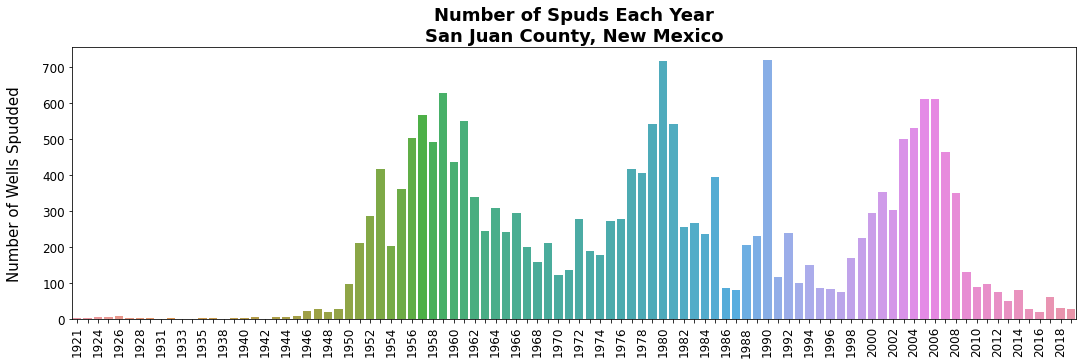

In [0]:
#Filter to only wells in San Juan County that were spudded after 1900
df_wells_plot = df_wells[(df_wells['spud_date'].dt.year > 1900) & (df_wells['county'] == 'San Juan')]

#Group by years and count the spuds in each year
count_spuds = df_wells_plot.groupby(df_wells_plot['spud_date'].dt.year).count()
count_spuds= count_spuds.rename(columns = {'spud_date':'Num Spuds'})
count_spuds = count_spuds.reset_index()

#Barplot
fig, ax = plt.subplots(figsize = (18,5))
ax = sns.barplot(x = 'spud_date', y = 'Num Spuds', data = count_spuds)
plt.xticks(rotation = 90)

#Format labels 
ax.set_title('Number of Spuds Each Year\nSan Juan County, New Mexico', size = 18, weight = 'bold')
ax.set_xlabel('')
ax.set_ylabel('Number of Wells Spudded', size = 15, labelpad = 20)
ax.tick_params(labelsize = 12)

#Every other x tick label visible
for label in ax.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)

**Visualize the total number of wells across New Mexico with an animated plot.**

In [0]:
#Create a list of dfs that each have one more year's wells than the previous df
years_list = []
for year in np.arange(1921, 2020):
  df = df_wells_plot[(df_wells_plot['year_spudded'] > 1920) & (df_wells_plot['year_spudded'] < year)]
  years_list.append(df)

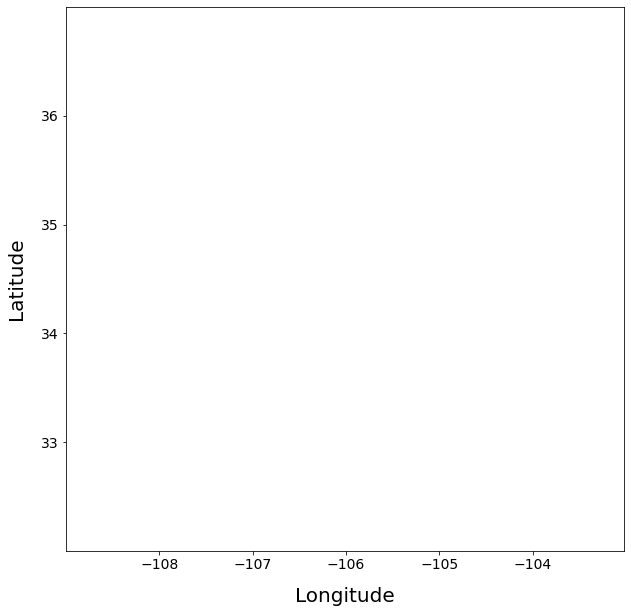

In [0]:
#Create animation that does not have a basemap
plt.rc('xtick', labelsize = 14)
plt.rc('ytick', labelsize = 14)
plt.rc('axes', labelsize= 20, labelpad = 15)

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(xlim=(df_wells_plot['longitude'].min(), df_wells_plot['longitude'].max()), ylim=(df_wells_plot['latitude'].min(), df_wells_plot['latitude'].max()),
              xlabel = 'Longitude', ylabel = 'Latitude')

graph, = ax.plot([], [], 'o',alpha = 0.03)

#Title. Set the position and other parameters except that text which we specift as '' for now.
title = ax.text(0.5, 1.05,'', size = 20, transform=ax.transAxes, ha = 'center')


# initialization function: plot the background of each frame
def init():
    graph.set_data([], [])
    return graph,

# animation function of dataframes' list
def animate(i):
    #Plot the data from each df within the list
    graph.set_data(years_list[i]['longitude'], years_list[i]['latitude'])

    #Adjust the titl to reflect the year
    title.set_text(u"Spudded O&G Wells in NM\nYear: {}".format(i + 1920))

    #Return both the graph and the title for each frame
    return graph, title,

#Set number of frames to the length of your list of dataframes so that each frame is one year
anim = animation.FuncAnimation(fig, animate, frames=len(years_list), init_func=init, interval=300, blit=True)

#This will show all the static components. To make the animation run anim
plt.show()

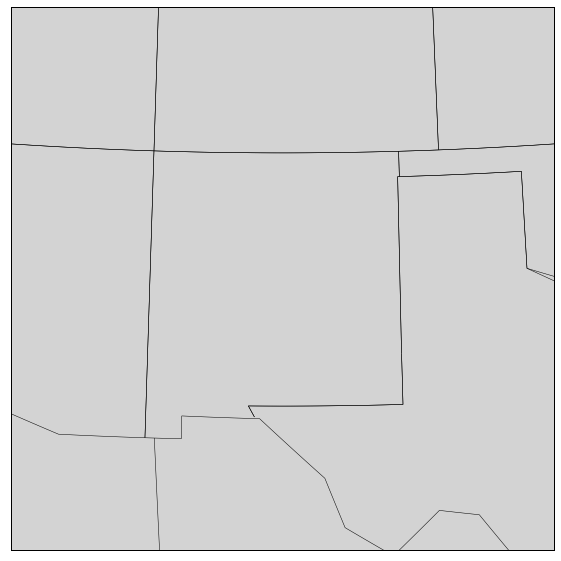

In [0]:
#Create animation that does have a basemap

#Size of plot
fig, ax = plt.subplots(figsize = (10,10))

#Create static map centered on coords lat_0 and lon_0
m = Basemap(width=1194000, height=1194000, projection='lcc',
            resolution='c', lat_0= 34.5199, lon_0=-105.8701)

#Add map elements
m.drawcoastlines()
m.drawmapboundary(fill_color='lightgrey')
m.drawstates()
m.drawcountries()

x,y = m(0, 0)
graph = m.plot(x, y, 'ro', markersize=5, alpha = 0.3)[0]

#Set params for dynamic title
title = ax.text(0.525, 0.85,'', size = 20, transform=ax.transAxes, ha = 'center')

def init():
    graph.set_data([], [])
    return graph,

def animate(i):
    x, y = m(years_list[i]['longitude'].values, years_list[i]['latitude'].values)
    graph.set_data(x, y)
    title.set_text(u"Spudded O&G Wells in NM\nYear: {}".format(i + 1920))
    return graph,title


anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(years_list), interval=150, blit=True)

plt.show()

In [0]:
#View the animated product
anim

In [0]:
#Save as a mp4
anim.save('nm_spuds.mp4')

**What companies have been spudding the most in San Juan County since 2010? We are only looking at wells with a status code of active.**

Text(0.5, 1.0, 'Number of New Wells Spudded Since 2010\nSan Juan County, NM')

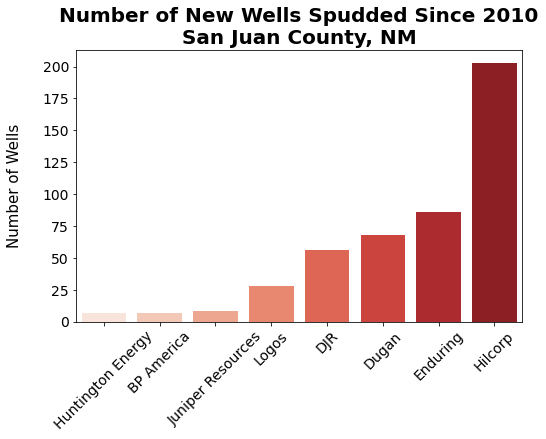

In [0]:
#Prepare data to count how many wells
df_wells_barplot = df_wells[(df_wells['county'] == 'San Juan') & (df_wells['spud_date'].dt.year > 2009) & (df_wells['status_code'] == 'A')]
df_wells_barplot = df_wells_barplot.groupby('ogrid_name').count().sort_values(by = 'id').reset_index()
df_wells_barplot = df_wells_barplot[df_wells_barplot['ogrid'] > 5]

#Create figure
fig,ax = plt.subplots(figsize = (8,5))
ax = sns.barplot(x = 'ogrid_name', y = 'id', data = df_wells_barplot, palette = 'Reds')

#Figure formatting
ax.set_xticklabels(['Huntington Energy', 'BP America',
                    'Juniper Resources', 'Logos',
                    'DJR', 'Dugan',
                    'Enduring', 'Hilcorp'])
plt.xticks(rotation = 45)

#Labels
ax.set_xlabel('')
ax.set_ylabel('Number of Wells', size = 15, labelpad = 20)
ax.set_title('Number of New Wells Spudded Since 2010\nSan Juan County, NM', size = 20, weight = 'bold')

**What is the break down of oil or gas wells operated by Hilcorp or Enduring (top 2 spudding companies based on previous figure)?**

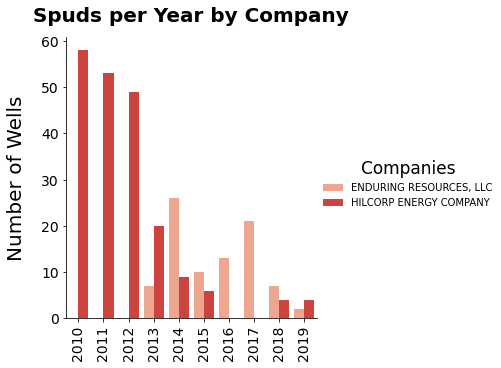

In [0]:
df_spud_hil_end = df_wells[(df_wells['county'] == 'San Juan') & (df_wells['spud_date'].dt.year > 2009) & (df_wells['status_code'] == 'A') & (df_wells['ogrid_name'].isin(['ENDURING RESOURCES, LLC','HILCORP ENERGY COMPANY']))]

#How many wells by each company?
plot =  df_spud_hil_end.groupby(['ogrid_name', 'year_spudded']).count() 
plot = plot.rename(columns = {'spud_date':'Num Spud'})
plot = plot.reset_index()

g = sns.catplot(x = 'year_spudded', y = 'Num Spud', data = plot, hue = 'ogrid_name', kind = 'bar', palette = 'Reds', legend = True)
axes = g.axes.flatten()
axes[0].set_title('Spuds per Year by Company', size = 20, weight = 'bold', pad = 15)
axes[0].set_xlabel('')
axes[0].set_ylabel('Number of Wells')
plt.xticks(rotation = 90)

#Edit legend
g._legend.set_title('Companies')

## Well Clustering and Facility Association

**Split up the data**

In [0]:
#Only hilcorp wells
hilcorp = df_wells[(df_wells['county'] == 'San Juan') &
                   (df_wells['spud_date'].dt.year > 2009) &
                   (df_wells['status_code'] == 'A') &
                   (df_wells['ogrid_name'].isin(['HILCORP ENERGY COMPANY']))]
hilcorp_gas = hilcorp[hilcorp['type_code'] == 'G']
hilcorp_oil = hilcorp[hilcorp['type_code'] == 'O']

#Only enduring wells
enduring = df_wells[(df_wells['county'] == 'San Juan') &
                   (df_wells['spud_date'].dt.year > 2009) &
                   (df_wells['status_code'] == 'A') &
                   (df_wells['ogrid_name'].isin(['ENDURING RESOURCES, LLC']))]
enduring_gas = enduring[enduring['type_code'] == 'G']
enduring_oil = enduring[enduring['type_code'] == 'O']

### Enduring Gas Analysis

**First step is to visualize all the new Enduring gas wells.**

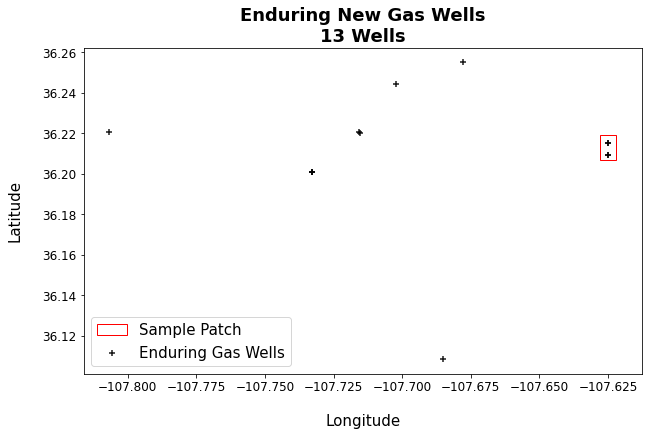

In [0]:
#Plot all new gas wells for enduring
fig, ax = plt.subplots(figsize=[10, 6])
df_scatter = ax.scatter(enduring_gas['longitude'], enduring_gas['latitude'], c='k', alpha=0.9, s=40, marker = '+', label = 'Enduring Gas Wells')

#Find the number of enduring gas wells
wells = enduring_gas.shape[0]

#Format labels
ax.set_title('Enduring New Gas Wells\n' + str(wells) + ' Wells', size = 18, fontweight = 'bold')
ax.set_xlabel('Longitude', size = 15, labelpad = 20)
ax.set_ylabel('Latitude', size = 15, labelpad = 20)
ax.tick_params(labelsize = 12)

rect = patches.Rectangle((-107.628, 36.207), width = 0.006, height = 0.012,
                         linewidth = 1, edgecolor = 'r', facecolor='none', label = 'Sample Patch')

ax.add_patch(rect)

#ax.legend([df_scatter,], ['Enduring Gas Wells'], loc= 'lower left', prop = {'size':15})
ax.legend(loc= 'lower left', prop = {'size':15})
plt.show()

**With satellite imagery we can visualize the wells on the right hand side of the above scatterplot.**

![picture](https://drive.google.com/uc?id=1I4g6WCDGsJM1I6Yk28zAv5r1UAGh3U6L)

**The next step is to cluster wells together. Clustering is an important step because instead of associating individual wells with facilities, we can associate well clusters (only one point) with facilities. This will cut down the time it takes to run the code in the case of using MANY wells.**

**DBSCAN is a clustering algorithm that groups points together based on their density. We are only only using the coordinates to cluster points, but theoretically you could use other information**

Useful description of DBSCAN for later: https://www.datanovia.com/en/lessons/dbscan-density-based-clustering-essentials/

In [0]:
#Matrix of all the well coordinates
coords = enduring_gas[['latitude', 'longitude']].values

#DBSCAN requires two inputs other than data: minimum number of samples per cluster and the distance to associate points
kms_per_radian = 6371.0088
epsilon = 0.4 / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 8


**Now need to find the centerpoint of all the clusters determined above.**

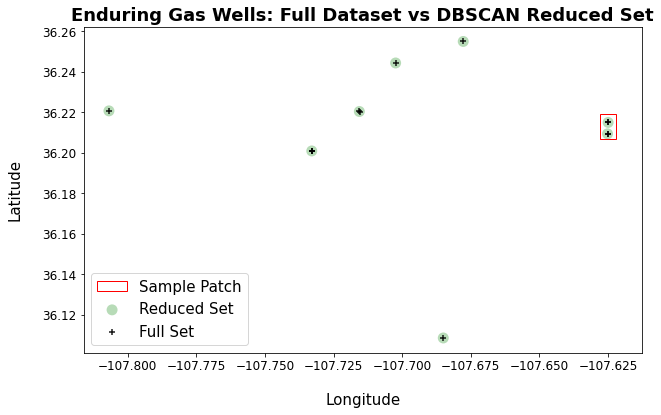

In [0]:
#Function to determine centermost points 
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

#Find centermost points in each cluster
centermost_points = clusters.map(get_centermost_point)

#Save centerpoints as a df
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})


rs = rep_points.apply(lambda row: enduring_gas[(enduring_gas['latitude']==row['lat'])&(enduring_gas['longitude']==row['lon'])].iloc[0], axis=1)

#Create plot
fig, ax = plt.subplots(figsize=[10, 6])

#Plot centerpoints
rs_scatter = ax.scatter(rs['longitude'], rs['latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120, label = 'Reduced Set')

#Plot individual well sites
df_scatter = ax.scatter(enduring_gas['longitude'], enduring_gas['latitude'], c='k', alpha=0.9, s=40, marker = '+', label = 'Full Set')

#Sample patch
rect = patches.Rectangle((-107.628, 36.207), width = 0.006, height = 0.012,
                         linewidth = 1, edgecolor = 'r', facecolor='none', label = 'Sample Patch')

ax.add_patch(rect)

#Formatting
ax.set_title('Enduring Gas Wells: Full Dataset vs DBSCAN Reduced Set', size = 18, fontweight = 'bold')
ax.set_xlabel('Longitude', size = 15, labelpad = 20)
ax.set_ylabel('Latitude', size = 15, labelpad = 20)
ax.tick_params(labelsize = 12)
ax.legend([df_scatter, rs_scatter], ['Gas Full set', 'Gas Reduced set'], loc='best')

ax.legend(loc= 'lower left', prop = {'size':15})
plt.show()

**In the original dataframe of gas wells, we want to know what cluster each observation was assigned to.**

In [0]:
#Empty column to store values
enduring_gas['Cluster'] = np.nan

#Iterate through an iterable of length clusters
for i in range(len(clusters)):

  #Get ith cluster
  cluster = clusters[i]

  #Iterate through each coord pair in cluster
  for j in cluster:
   enduring_gas.loc[(enduring_gas['latitude'] == j[0]) & (enduring_gas['longitude'] == j[1]), ['Cluster']] = int(i)


#Do the same with our centerpoints of wells. We want to know the cluster number associated with centerpoints.
rs['Cluster'] = np.nan

for i in range(len(clusters)):
  #Get ith cluster
  cluster = clusters[i]

  #Iterate through each coord pair in cluster
  for j in cluster:
   rs.loc[(rs['latitude'] == j[0]) & (rs['longitude'] == j[1]), ['Cluster']] = int(i)

rs

**Now it is time to associate facilities with well clusters. Start by filtering the dataframe of facilities down to ones that are within the general area, are considered oil and gas facilities, and within San Juan County.**

In [0]:
#Only oil and gas facilities in San Juan county
og_facilities = facilities[(facilities['Industry'].str.contains('O&G')) & (facilities['County'] == 'San Juan')]

##Filter out outliers by max lat and lon of well locations
#Bottom right: Must be less than or equal to this
max_lon = enduring_gas['longitude'].max() + 0.1

#Bottom left: Must be greater than or equal to this 
min_lon = enduring_gas['longitude'].min() - 0.1

#Top right: Must be less than or equal to this
max_lat = enduring_gas['latitude'].max() +0.1

#Top: Must be greater than or equal to this
min_lat = enduring_gas['latitude'].min() - 0.1

#Facilities inside the box (need to tweak boundaries)
og_facilities = og_facilities[(og_facilities['Latitude'].between(min_lat,max_lat, inclusive = True)) & (og_facilities['Longitude'].between(min_lon,max_lon, inclusive = True))]

**Visualize well clusters and facilities on the same figure.**

In [0]:
#Create figure
fig, ax = plt.subplots(figsize=[10, 6])

#Plot centerpoints of well clusters
rs_scatter = ax.scatter(rs['longitude'], rs['latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120, label = 'Well Clusters')

#Plot filtered facilities
fac_scatter = ax.scatter(og_facilities['Longitude'], og_facilities['Latitude'], c='blue', edgecolor='None', alpha=0.7, s=25, label = 'O&G Facilities')

#Sample patch
rect = patches.Rectangle((-107.628, 36.207), width = 0.006, height = 0.012,
                         linewidth = 1, edgecolor = 'r', facecolor='none', label = 'Sample Patch')

ax.add_patch(rect)

#Formatting
ax.set_title('Enduring Gas Well Clusters vs Facility Location', size = 18, fontweight = 'bold')
ax.set_xlabel('Longitude', size = 15, labelpad = 20)
ax.set_ylabel('Latitude', size = 15, labelpad = 20)
ax.tick_params(labelsize = 12)

ax.legend([rs_scatter, fac_scatter], ['Gas Well Clusters', 'Facilities'], loc='upper right')

ax.legend(loc= 'lower left', prop = {'size':15})
plt.show()

**In order to associate facilities with wells, we need to calculate the distance between each well cluster and the facility. Since the observations occur on Earh's surface, the most appropriate distance metric is Haversine.**

In [0]:
#Haversine function for distance calculation
import math

def haversine(coord1, coord2):
    R = 6372800  # Earth radius in meters
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

**Calculate the distance between each of the well clusters and the facilities using the Haversine function. If a facility is less than 200 meters away, it is considered associated. If no facilities are found within 200 meters, store the facilities as isolated and they will be used in another analysis.**

In [0]:
#I want to have a seperate path for isolated well sites.
#So if no facilities within 200 m, I want to expand search radius to 500
#Need a running count of the number of faciliites per well

og_facilities['Cluster'] = np.nan

#How many facilities per center point?
isolated = []

#Iterate through center points
for i in rs['id'].unique():
  well_lat = rs[rs['id'] == i]['latitude'].values[0]
  well_lon = rs[rs['id'] == i]['longitude'].values[0]
  well_point = (well_lat, well_lon)

  #Get cluster values
  cluster_num = rs[rs['id'] == i]['Cluster'].values[0]
  
  count = 0

  #Iterate through facilities
  for j in og_facilities['AI'].unique():
    fac_lat = og_facilities[og_facilities['AI'] == j]['Latitude'].values[0]
    fac_lon = og_facilities[og_facilities['AI'] == j]['Longitude'].values[0]
    fac_point = (fac_lat, fac_lon)

    distance = haversine(well_point, fac_point)

    if distance < 200:
      print(i, j, cluster_num)
      #Label it with cluster number of rs center point
      og_facilities.loc[og_facilities['AI'] == j, ['Cluster']] = cluster_num

      count = count + 1
      
    #Too far away to be associated
    else:
      continue

  if count == 0:
    isolated.append(i)

  else:
    continue

**Take the list of isolated facilities and crank up the distance to 500 m to find any nearby facilities.**

In [0]:
#Iterate through center points
for i in np.unique(isolated):
  well_lat = rs[rs['id'] == i]['latitude'].values[0]
  well_lon = rs[rs['id'] == i]['longitude'].values[0]
  well_point = (well_lat, well_lon)

  #Get cluster values
  cluster_num = rs[rs['id'] == i]['Cluster'].values[0]

  #Iterate through facilities
  for j in og_facilities['AI'].unique():
    fac_lat = og_facilities[og_facilities['AI'] == j]['Latitude'].values[0]
    fac_lon = og_facilities[og_facilities['AI'] == j]['Longitude'].values[0]
    fac_point = (fac_lat, fac_lon)

    distance = haversine(well_point, fac_point)

    if distance < 500:
      print(i, j, cluster_num)
      og_facilities.loc[og_facilities['AI'] == j, ['Cluster']] = cluster_num
      #Label it with cluster number of rs center point

    #Too far away to be associated
    else:
      continue

**Inner join facilities and wells together based on their cluster. Inner join will remove facilities that did not have a cluster. Filter to only useful columns.**

In [0]:
#So now we can join the facilities and wells df

df_well_fac = enduring_gas.merge(og_facilities, on = 'Cluster', how = 'inner', suffixes = ('_well', '_fac'))

df_well_fac_filter = df_well_fac[['spud_date', 'id', 'name', 'ogrid_name', 'latitude', 
                                  'longitude', 'AI', 'Facility Name', 'Cluster', 'Latitude', 'Longitude',
                                  'NO_TPY','CO_TPY','VOC_TPY','PM10_TPY','SO2_TPY']]

#Rename columns
df_well_fac_filter = df_well_fac_filter.rename(columns = {'latitude':'Well Latitude',
                                    'longitude':'Well Longitude',
                                    'Latitude':'Facility Latitude',
                                    'Longitude':'Facility Longitude',
                                    'name':'Well Name',
                                    'API':'Well API',
                                    'AI':'Facility AI'})

#Save as csv
df_well_fac_filter.to_csv('enduring_gas_well_facility_match.csv')

**Plot the final results.**

In [0]:
#Plot
fig, ax = plt.subplots(figsize= (10, 6))

#Scatter of well center points
rs_scatter = ax.scatter(rs['longitude'], rs['latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120, label = 'Well Cluster')

#Scatter of associated facilities
fac_scatter = ax.scatter(df_well_fac_filter['Facility Longitude'], df_well_fac_filter['Facility Latitude'], c='blue', edgecolor='None', alpha=0.7, s=25, label = 'O&G Facilities')

#Sample patch
rect = patches.Rectangle((-107.628, 36.207), width = 0.006, height = 0.012,
                         linewidth = 1, edgecolor = 'r', facecolor='none', label = 'Sample Patch')
ax.add_patch(rect)

#Formatting
ax.set_title('Enduring Gas Well Clusters vs Facility Location', size = 18, fontweight = 'bold')
ax.set_xlabel('Longitude', size = 15, labelpad = 20)
ax.set_ylabel('Latitude', size = 15, labelpad = 20)
ax.tick_params(labelsize = 12)

ax.legend(loc= 'lower left', prop = {'size':15})
plt.show()

In [0]:
df_well_fac_filter

**Visualize the sample patch of well with high resolution imagery. The DBSCAN 0.4 km buffer is included. The facility to well associationdistance (0.2 km) is not included.**

![picture](https://drive.google.com/uc?id=1AXrBnzoGz1hhhszAHywqnKNeDCXsskj5)

# Large scale clustering

In [0]:
sj_wells = df_wells[(df_wells['county'] == 'San Juan') &
                   (df_wells['spud_date'].dt.year > 2000) &
                   (df_wells['status_code'] == 'A')]

enduring_gas = sj_wells

NameError: ignored

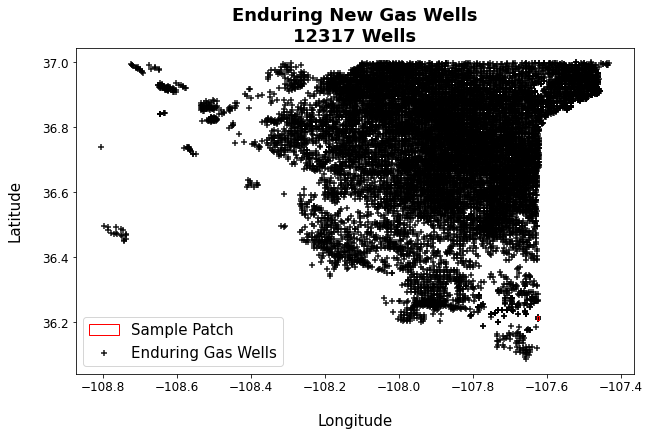

In [0]:
#Plot all new gas wells for enduring
fig, ax = plt.subplots(figsize=[10, 6])
df_scatter = ax.scatter(enduring_gas['longitude'], enduring_gas['latitude'], c='k', alpha=0.9, s=40, marker = '+', label = 'Enduring Gas Wells')

#Find the number of enduring gas wells
wells = enduring_gas.shape[0]

#Format labels
ax.set_title('Enduring New Gas Wells\n' + str(wells) + ' Wells', size = 18, fontweight = 'bold')
ax.set_xlabel('Longitude', size = 15, labelpad = 20)
ax.set_ylabel('Latitude', size = 15, labelpad = 20)
ax.tick_params(labelsize = 12)

rect = patches.Rectangle((-107.628, 36.207), width = 0.006, height = 0.012,
                         linewidth = 1, edgecolor = 'r', facecolor='none', label = 'Sample Patch')

ax.add_patch(rect)

#ax.legend([df_scatter,], ['Enduring Gas Wells'], loc= 'lower left', prop = {'size':15})
ax.legend(loc= 'lower left', prop = {'size':15})
plt.show()

In [0]:
#Matrix of all the well coordinates
coords = enduring_gas[['latitude', 'longitude']].values

#DBSCAN requires two inputs other than data: minimum number of samples per cluster and the distance to associate points
kms_per_radian = 6371.0088
epsilon = 5 / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 7
